In [1]:
import pandas as pd
import numpy as np
import regex as re

import joblib
from tqdm import tqdm
import time
import logging
from dataclasses import dataclass, field


import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from scipy import stats
from scipy.stats import skew
from joblib import dump, load

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, GridSearchCV, ParameterGrid, train_test_split, StratifiedKFold

# we need this for classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor , RandomForestClassifier, BaggingClassifier, StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMClassifier

#!pip install catboost
from catboost import CatBoostClassifier


from sklearn.base import clone, BaseEstimator
from typing import List, Tuple, Union,Any, Optional, Dict




In [2]:
df = pd.read_csv("csv_files/healthcare-dataset-stroke-data.csv")

In [3]:
df.columns = df.columns.str.lower()

In [4]:
#drop the only "other" in gender column
df = df[df['gender'] != 'Other']


In [5]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 518.9+ KB


## Non Ordinal ML


### Rows to Numeric - For Non Ordinal ML

In [7]:
dfv1 = df.copy()

In [8]:
dfv1

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [9]:
dfv1['gender'].unique()


array(['Male', 'Female'], dtype=object)

In [10]:
dfv1['work_type'].unique()


array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [11]:
dfv1['residence_type'].unique()


array(['Urban', 'Rural'], dtype=object)

In [12]:
dfv1['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [13]:
"""
Gender collumn :
    Male = 1
    Female = 0

Age Collumn:
    Its fine

Hypertension:
    Its fine

Heart Disease:
    Its fine

ever_married:
    Yes = 1
    No = 0

work_type:
    Private = 1
    Self-employed = 1
    Govt_job = 1
    children = 1
    Never_worked = 1

residence_type:
    Urban = 1
    Rural = 0

avg_glucose_level:
    Its fine

bmi:
    delete missing values

smoking_status:
    never smoked = 1
    formerly smoked = 1
    smokes = 1
    Unknown = 1

"""
    
    

'\nGender collumn :\n    Male = 1\n    Female = 0\n\nAge Collumn:\n    Its fine\n\nHypertension:\n    Its fine\n\nHeart Disease:\n    Its fine\n\never_married:\n    Yes = 1\n    No = 0\n\nwork_type:\n    Private = 1\n    Self-employed = 1\n    Govt_job = 1\n    children = 1\n    Never_worked = 1\n\nresidence_type:\n    Urban = 1\n    Rural = 0\n\navg_glucose_level:\n    Its fine\n\nbmi:\n    delete missing values\n\nsmoking_status:\n    never smoked = 1\n    formerly smoked = 1\n    smokes = 1\n    Unknown = 1\n\n'

In [14]:
dfv1.dropna(subset=['bmi'], inplace=True)

In [15]:
# convert gender to numeric

In [16]:
dfv1['gender_numeric'] = df['gender'].map({'Male': 1, 'Female': 0})


In [17]:
dfv1.drop(columns=['gender'], inplace=True)

In [18]:
dfv1['ever_married_numeric'] = df['ever_married'].map({'Yes': 1, 'No': 0})

In [19]:
dfv1.drop(columns=['ever_married'], inplace=True)

In [20]:
dfv1['work_type'].unique()


array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [21]:
dfv1['work_type_private'] = (dfv1['work_type'].str.lower() == 'private').astype(int)
dfv1['work_type_self_employed'] = (dfv1['work_type'].str.lower() == 'self-employed').astype(int)
dfv1['work_type_govt_job'] = (dfv1['work_type'].str.lower() == 'govt_job').astype(int)
dfv1['work_type_children'] = (dfv1['work_type'].str.lower() == 'children').astype(int)
dfv1['work_type_never_worked'] = (dfv1['work_type'].str.lower() == 'never_worked').astype(int)

In [22]:
dfv1.drop(columns=['work_type'], inplace=True)

In [23]:
dfv1['residence_type_numeric'] = df['residence_type'].map({'Rural': 0, 'Urban': 1})

In [24]:
dfv1.drop(columns=['residence_type'], inplace=True)

In [25]:
dfv1['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [26]:
dfv1['smoke_status_formerly_smoked'] = (dfv1['smoking_status'].str.lower() == 'formerly smoked').astype(int)
dfv1['smoke_status_never_smoked'] = (dfv1['smoking_status'].str.lower() == 'never smoked').astype(int)
dfv1['smoke_status_smokes'] = (dfv1['smoking_status'].str.lower() == 'smokes').astype(int)
dfv1['smoke_status_unknown'] = (dfv1['smoking_status'].str.lower() == 'unknown').astype(int)

In [27]:
dfv1.drop(columns=['smoking_status'], inplace=True)

In [28]:
dfv1.drop(columns=['id'], inplace=True)

### KNN Classifier

In [29]:
dfv1.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_numeric', 'ever_married_numeric', 'work_type_private',
       'work_type_self_employed', 'work_type_govt_job', 'work_type_children',
       'work_type_never_worked', 'residence_type_numeric',
       'smoke_status_formerly_smoked', 'smoke_status_never_smoked',
       'smoke_status_smokes', 'smoke_status_unknown'],
      dtype='object')

In [30]:
dfv1

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_numeric,smoke_status_formerly_smoked,smoke_status_never_smoked,smoke_status_smokes,smoke_status_unknown
0,67.0,0,1,228.69,36.6,1,1,1,1,0,0,0,0,1,1,0,0,0
2,80.0,0,1,105.92,32.5,1,1,1,1,0,0,0,0,0,0,1,0,0
3,49.0,0,0,171.23,34.4,1,0,1,1,0,0,0,0,1,0,0,1,0
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,0,0,0,1,0,0
5,81.0,0,0,186.21,29.0,1,1,1,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,0,0,0,1,0,0,0,0,0,1
5106,81.0,0,0,125.20,40.0,0,0,1,0,1,0,0,0,1,0,1,0,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,1,0,0,0,0,0,1,0,0
5108,51.0,0,0,166.29,25.6,0,1,1,1,0,0,0,0,0,1,0,0,0


In [31]:
features = dfv1.drop(columns = ["stroke"])
target = dfv1["stroke"]

In [32]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(features, target, test_size = 0.20, random_state=0)

In [33]:
normalizer = StandardScaler()

In [34]:
normalizer.fit(X_train_knn)

StandardScaler()

In [35]:
X_train_norm_knn = normalizer.transform(X_train_knn)

X_test_norm_knn = normalizer.transform(X_test_knn)

In [36]:
X_train_norm_knn = pd.DataFrame(X_train_norm_knn, columns = X_train_knn.columns)
X_test_norm_knn = pd.DataFrame(X_test_norm_knn, columns = X_test_knn.columns)

In [37]:
knn = KNeighborsClassifier(n_neighbors=4)

In [38]:
knn.fit(X_train_norm_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=4)

In [39]:
knn.score(X_test_norm_knn, y_test_knn)

0.9562118126272913

In [40]:
def tune_hyperparameter(model_class, param_name, param_values, X_train, y_train, X_test, y_test):
    """
    Test different values of a single hyperparameter for a given model and return the best one.

    Parameters:
    - model_class: e.g., KNeighborsClassifier, RandomForestClassifier
    - param_name: str, name of the hyperparameter (e.g., 'n_neighbors', 'max_depth')
    - param_values: list of values to test
    - X_train, y_train: training data
    - X_test, y_test: test data

    Returns:
    - best_param: the value of the hyperparameter that gave the best accuracy
    - best_score: the corresponding accuracy
    - scores: list of (param_value, accuracy) tuples
    """

    scores = []

    for val in param_values:
        params = {param_name: val}
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append((val, acc))
        print(f"{param_name} = {val}, Accuracy = {acc:.4f}")

    # Find the best one
    best_param, best_score = max(scores, key=lambda x: x[1])
    print(f"\n✅ Best {param_name}: {best_param} with Accuracy: {best_score:.4f}")

    # Plotting
    vals = [val for val, _ in scores]
    accs = [acc for _, acc in scores]
    plt.figure(figsize=(10, 5))
    plt.plot(vals, accs, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"{model_class.__name__} Accuracy vs {param_name}")
    plt.grid(True)
    plt.show()

    return best_param, best_score, scores

n_neighbors = 1, Accuracy = 0.9226
n_neighbors = 2, Accuracy = 0.9521
n_neighbors = 3, Accuracy = 0.9521
n_neighbors = 4, Accuracy = 0.9562
n_neighbors = 5, Accuracy = 0.9552
n_neighbors = 6, Accuracy = 0.9552
n_neighbors = 7, Accuracy = 0.9552
n_neighbors = 8, Accuracy = 0.9562
n_neighbors = 9, Accuracy = 0.9562
n_neighbors = 10, Accuracy = 0.9562
n_neighbors = 11, Accuracy = 0.9562
n_neighbors = 12, Accuracy = 0.9562
n_neighbors = 13, Accuracy = 0.9562
n_neighbors = 14, Accuracy = 0.9562
n_neighbors = 15, Accuracy = 0.9562
n_neighbors = 16, Accuracy = 0.9562
n_neighbors = 17, Accuracy = 0.9562
n_neighbors = 18, Accuracy = 0.9562
n_neighbors = 19, Accuracy = 0.9562
n_neighbors = 20, Accuracy = 0.9562
n_neighbors = 21, Accuracy = 0.9562
n_neighbors = 22, Accuracy = 0.9562
n_neighbors = 23, Accuracy = 0.9562
n_neighbors = 24, Accuracy = 0.9562
n_neighbors = 25, Accuracy = 0.9562
n_neighbors = 26, Accuracy = 0.9562
n_neighbors = 27, Accuracy = 0.9562
n_neighbors = 28, Accuracy = 0.9562
n

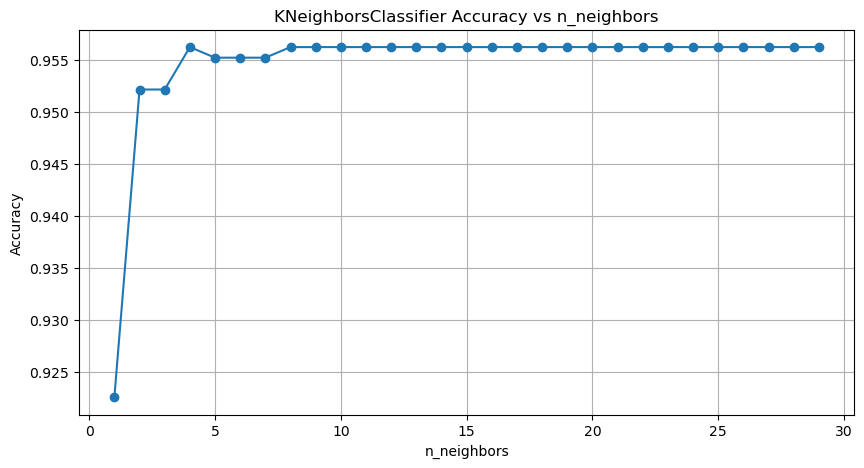

In [41]:
best_k, best_score, all_scores = tune_hyperparameter(
    model_class=KNeighborsClassifier,
    param_name='n_neighbors',
    param_values=range(1, 30),
    X_train=X_train_norm_knn,
    y_train=y_train_knn,
    X_test=X_test_norm_knn,
    y_test=y_test_knn
)

In [42]:
dfv1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4908 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           4908 non-null   float64
 1   hypertension                  4908 non-null   int64  
 2   heart_disease                 4908 non-null   int64  
 3   avg_glucose_level             4908 non-null   float64
 4   bmi                           4908 non-null   float64
 5   stroke                        4908 non-null   int64  
 6   gender_numeric                4908 non-null   int64  
 7   ever_married_numeric          4908 non-null   int64  
 8   work_type_private             4908 non-null   int32  
 9   work_type_self_employed       4908 non-null   int32  
 10  work_type_govt_job            4908 non-null   int32  
 11  work_type_children            4908 non-null   int32  
 12  work_type_never_worked        4908 non-null   int32  
 13  residenc

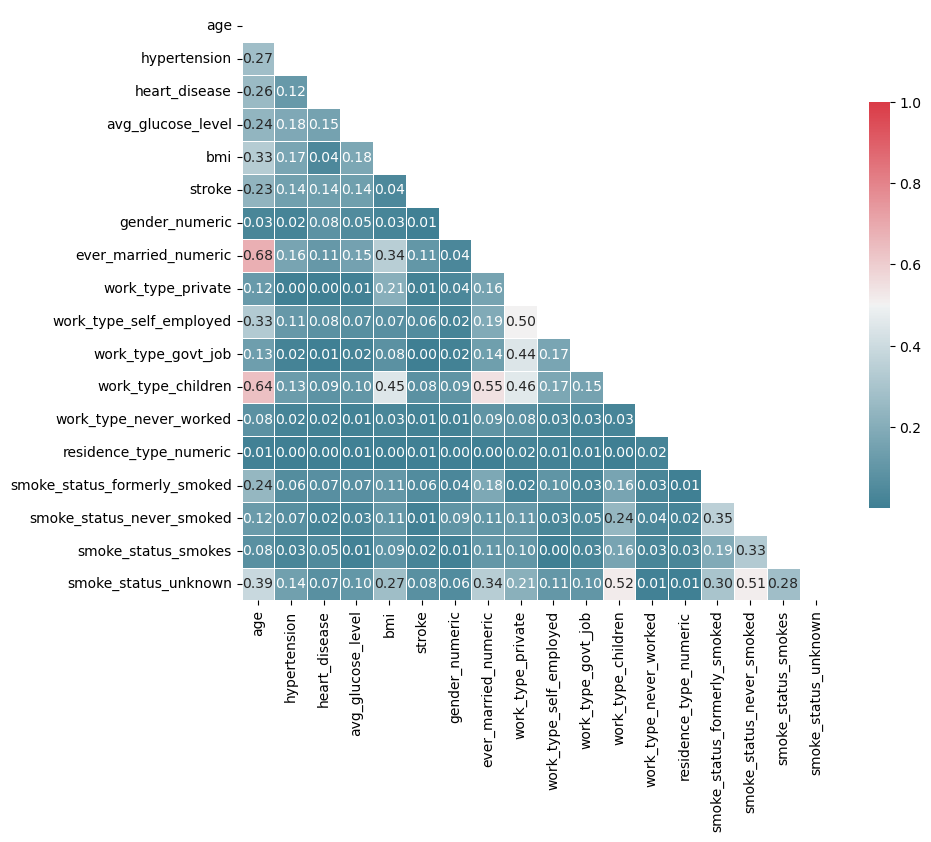

In [43]:
corr=np.abs(dfv1.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5},
    annot=True,  # Show numbers
    fmt=".2f",  # Format numbers to 2 decimals
    annot_kws={"size": 10, "ha": 'center', "va": 'center'}  # Style annotations
)
plt.tight_layout()
plt.show()

In [44]:
def print_all_metrics(y_true, y_pred, y_prob=None, positive_label=1):
    """
    Print a full set of classification metrics:
      - accuracy
      - classification_report (precision, recall, f1, support)
      - confusion matrix, plus derived sensitivity/specificity
      - (optional) ROC AUC if you pass in y_prob for the positive class

    Parameters:
        y_true      – ground‐truth labels
        y_pred      – predicted labels
        y_prob      – predicted probability (or score) for the positive class; if None, skip ROC AUC
        positive_label – which label is “positive” (default 1)
    """

    # 1) Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.3f}\n")

    # 2) Full classification report
    print("Classification report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    # 3) Confusion matrix → derive sensitivity (recall) & specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, positive_label]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    print("Confusion matrix (true_neg, false_pos, false_neg, true_pos):")
    print(f"    TN = {tn},  FP = {fp}")
    print(f"    FN = {fn},  TP = {tp}\n")
    print(f"Sensitivity (Recall₁) = {sensitivity:.3f}")
    print(f"Specificity (Recall₀) = {specificity:.3f}\n")

    # 4) Precision/Recall/F1 (for positive_label)
    p = precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    r = recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    print(f"Precision (PPV)₁ = {p:.3f}")
    print(f"Recall (Sensitivity)₁ = {r:.3f}")
    print(f"F1-score₁       = {f1:.3f}\n")

    # 5) (Optional) ROC AUC for the positive class
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob)
            print(f"ROC AUC (pos_label={positive_label}) = {auc:.3f}")
        except Exception:
            print("Could not compute ROC AUC (check y_prob).")


In [45]:
def grid_search_with_progress(estimator, param_grid, X, y, cv=5, scoring=None, verbose=0, n_jobs=None, chunk_size=1, **kwargs):
    """
    GridSearchCV with a tqdm progress bar that updates in chunks.

    Parameters:
        estimator: Scikit-learn estimator instance.
        param_grid: Dict specifying parameter grid.
        X, y: Feature matrix and target array.
        cv: Number of CV folds.
        scoring: Scoring metric or callable.
        verbose: Verbosity level passed to GridSearchCV.
        n_jobs: Number of parallel jobs.
        chunk_size: Number of parameter‐sets to evaluate before updating tqdm.
        kwargs: Additional kwargs for GridSearchCV.

    Returns:
        The fitted GridSearchCV object.
    """
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        verbose=verbose,
        n_jobs=n_jobs,
        **kwargs
    )

    total_combinations = len(list(ParameterGrid(param_grid)))
    print(f"Running Grid Search with {total_combinations} parameter combinations...")

    orig_run_search = grid_search._run_search  # backup the original method

    def new_run_search(evaluate_candidates):
        def patched_evaluate(candidates):
            candidates_list = list(candidates)  # convert to list for slicing
            for i in range(0, len(candidates_list), chunk_size):
                chunk = candidates_list[i : i + chunk_size]
                evaluate_candidates(chunk)
                pbar.update(len(chunk))
        return orig_run_search(patched_evaluate)

    grid_search._run_search = new_run_search

    with tqdm(total=total_combinations, desc="Grid Search Progress", unit="comb") as pbar:
        grid_search.fit(X, y)

    return grid_search


In [46]:
param_grid_knn = {
    'n_neighbors': list(range(1, 31)),               # Number of neighbors
    'weights': ['uniform', 'distance'],            # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for computing nearest neighbors
    'leaf_size': [20, 30, 40],                     # Leaf size for BallTree/KDTree
    'p': [1, 2],                                   # Power parameter for Minkowski metric: 1=Manhattan, 2=Euclidean
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Distance metric
}

In [47]:
#grid_search_knn01 = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)
#grid_search_knn01.fit(X_train_norm_knn, y_train_knn)

In [48]:
#joblib.dump(grid_search_knn01, 'gridsearch/knn01_gridsearch.pkl')

In [49]:
grid_knn01 = joblib.load('gridsearch/knn01_gridsearch.pkl')

In [50]:
grid_knn01.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 11,
 'p': 1,
 'weights': 'uniform'}

In [51]:
model_knn01 = grid_knn01.best_estimator_

In [52]:
model_knn01.fit(X_train_norm_knn,y_train_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=11, p=1)

In [53]:
print(y_train_knn.value_counts(normalize=True))
print(y_train_knn.value_counts())

stroke
0    0.957718
1    0.042282
Name: proportion, dtype: float64
stroke
0    3760
1     166
Name: count, dtype: int64


In [54]:
y_pred = knn.predict(X_test_knn)

In [55]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       939
           1       0.00      0.00      0.00        43

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.96      0.93       982



c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### KNN Oversampling

In [56]:
dfv1

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_numeric,smoke_status_formerly_smoked,smoke_status_never_smoked,smoke_status_smokes,smoke_status_unknown
0,67.0,0,1,228.69,36.6,1,1,1,1,0,0,0,0,1,1,0,0,0
2,80.0,0,1,105.92,32.5,1,1,1,1,0,0,0,0,0,0,1,0,0
3,49.0,0,0,171.23,34.4,1,0,1,1,0,0,0,0,1,0,0,1,0
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,0,0,0,1,0,0
5,81.0,0,0,186.21,29.0,1,1,1,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,0,0,0,1,0,0,0,0,0,1
5106,81.0,0,0,125.20,40.0,0,0,1,0,1,0,0,0,1,0,1,0,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,1,0,0,0,0,0,1,0,0
5108,51.0,0,0,166.29,25.6,0,1,1,1,0,0,0,0,0,1,0,0,0


In [57]:
stroke = dfv1[dfv1["stroke"] == 1]
no_stroke = dfv1[dfv1["stroke"] == 0]

In [58]:
yes_stroke_oversampled = resample(no_stroke, 
                                    replace=True, 
                                    n_samples = len(stroke),
                                    random_state=0)

In [59]:
train_over = pd.concat([yes_stroke_oversampled, stroke])
train_over

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_numeric,smoke_status_formerly_smoked,smoke_status_never_smoked,smoke_status_smokes,smoke_status_unknown
3085,73.0,0,1,72.42,27.6,0,1,1,1,0,0,0,0,0,0,1,0,0
2953,53.0,0,0,95.47,26.0,0,1,1,1,0,0,0,0,0,0,0,1,0
1965,5.0,0,0,109.40,20.0,0,0,0,0,0,0,1,0,0,0,0,0,1
3637,82.0,0,0,226.84,25.3,0,1,1,1,0,0,0,0,1,1,0,0,0
1312,3.0,0,0,97.60,25.8,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,68.0,1,1,247.51,40.5,1,0,1,1,0,0,0,0,1,1,0,0,0
244,57.0,0,0,84.96,36.7,1,1,1,1,0,0,0,0,0,0,0,0,1
245,14.0,0,0,57.93,30.9,1,0,0,0,0,0,1,0,0,0,0,0,1
246,75.0,0,0,78.80,29.3,1,0,1,0,1,0,0,0,0,1,0,0,0


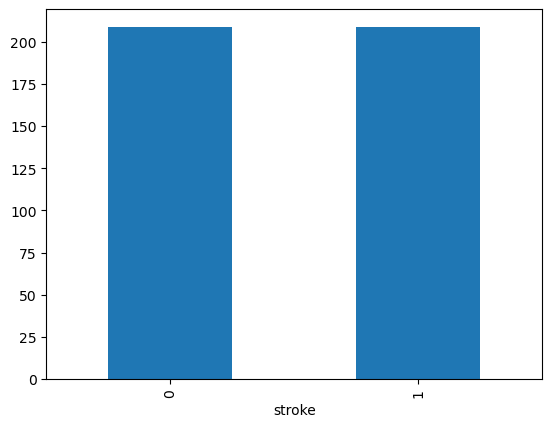

In [60]:
stroke = train_over["stroke"].value_counts()
stroke.plot(kind="bar")
plt.show()

In [61]:
X_train_over = train_over.drop(columns = ["stroke"])
y_train_over = train_over["stroke"]

In [62]:
best_params = {'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

# Option 1: instantiate from scratch using the best_params dict
model_knn02 = KNeighborsClassifier(**best_params)
model_knn02.fit(X_train_over, y_train_over)

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1)

In [63]:
y_pred = knn.predict(X_test_norm_knn)

In [64]:
print_all_metrics(
    y_true=y_test_knn,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Accuracy: 0.956

Classification report:

              precision    recall  f1-score   support

           0      0.957     0.999     0.978       939
           1      0.500     0.023     0.044        43

    accuracy                          0.956       982
   macro avg      0.729     0.511     0.511       982
weighted avg      0.937     0.956     0.937       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 938,  FP = 1
    FN = 42,  TP = 1

Sensitivity (Recall₁) = 0.023
Specificity (Recall₀) = 0.999

Precision (PPV)₁ = 0.500
Recall (Sensitivity)₁ = 0.023
F1-score₁       = 0.044



KNN SMOTE


In [65]:
sm = SMOTE(sampling_strategy=0.7)
X_res_knn, y_res_knn = sm.fit_resample(X_train_norm_knn, y_train_knn)


model_knn01.fit(X_res_knn, y_res_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=11, p=1)

In [66]:
model_knn01.score(X_test_norm_knn, y_test_knn)

0.8289205702647657

In [67]:
y_pred = model_knn01.predict(X_test_norm_knn)

In [68]:
print_all_metrics(
    y_true=y_test_knn,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Accuracy: 0.829

Classification report:

              precision    recall  f1-score   support

           0      0.970     0.848     0.905       939
           1      0.112     0.419     0.176        43

    accuracy                          0.829       982
   macro avg      0.541     0.633     0.541       982
weighted avg      0.932     0.829     0.873       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 796,  FP = 143
    FN = 25,  TP = 18

Sensitivity (Recall₁) = 0.419
Specificity (Recall₀) = 0.848

Precision (PPV)₁ = 0.112
Recall (Sensitivity)₁ = 0.419
F1-score₁       = 0.176



In [69]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90       939
           1       0.11      0.42      0.18        43

    accuracy                           0.83       982
   macro avg       0.54      0.63      0.54       982
weighted avg       0.93      0.83      0.87       982



In [70]:
param_grid_knn = {
    'n_neighbors': list(range(1, 17)),               # Number of neighbors
    'weights': ['uniform'],            # Weight function used in prediction
    'algorithm': ['auto'],  # Algorithm for computing nearest neighbors
    'leaf_size': [20],                     # Leaf size for BallTree/KDTree
    'p': [1, 2],                                   # Power parameter for Minkowski metric: 1=Manhattan, 2=Euclidean
    'metric': ['minkowski']  # Distance metric
}

In [71]:
#grid_search_knn02 = grid_search_with_progress(model_knn01, param_grid_knn, X_res_knn, y_res_knn, cv=5, scoring= 'f1')
#print("Best parameters found:", grid_search_knn02.best_params_)


In [72]:
#grid_search_knn02.best_params_

In [73]:
best_params = {'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

# Option 1: instantiate from scratch using the best_params dict
model_knn02 = KNeighborsClassifier(**best_params)
model_knn02.fit(X_res_knn, y_res_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1)

In [74]:
y_pred = model_knn02.predict(X_test_norm_knn)

In [75]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       939
           1       0.08      0.09      0.08        43

    accuracy                           0.91       982
   macro avg       0.52      0.52      0.52       982
weighted avg       0.92      0.91      0.91       982



In [76]:
'''

| Metric       | Good Start | Great (ideal) |
| ------------ | ---------- | ------------- |
| Precision\_1 | ≥ 0.30     | ≥ 0.70        |
| Recall\_1    | ≥ 0.50     | ≥ 0.80        |
| F1-score\_1  | ≥ 0.40     | ≥ 0.70        |

'''

<>:1: SyntaxWarning: invalid escape sequence '\_'
<>:1: SyntaxWarning: invalid escape sequence '\_'
C:\Users\estif\AppData\Local\Temp\ipykernel_17028\3083410714.py:1: SyntaxWarning: invalid escape sequence '\_'
  '''


'\n\n| Metric       | Good Start | Great (ideal) |\n| ------------ | ---------- | ------------- |\n| Precision\\_1 | ≥ 0.30     | ≥ 0.70        |\n| Recall\\_1    | ≥ 0.50     | ≥ 0.80        |\n| F1-score\\_1  | ≥ 0.40     | ≥ 0.70        |\n\n'

In [77]:
#grid_search_knn02 = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)
#grid_search_knn02.fit(X_res_knn, y_res_knn)


In [78]:
#joblib.dump(grid_search_knn02, 'gridsearch/knn02_gridsearch.pkl')

In [79]:
#grid_knn02 = joblib.load('gridsearch/knn02_gridsearch.pkl')

In [80]:
#grid_knn02.best_params_


In [81]:
#model_knn02 = grid_knn02.best_estimator_


In [82]:
model_knn02.fit(X_train_norm_knn,y_train_knn)

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1)

In [83]:
print(classification_report(y_test_knn, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       939
           1       0.08      0.09      0.08        43

    accuracy                           0.91       982
   macro avg       0.52      0.52      0.52       982
weighted avg       0.92      0.91      0.91       982



#### Test Model No heart_disease column


In [84]:
dfv1_nohd = dfv1.copy()

In [85]:
dfv1_nohd.drop(columns=['heart_disease'], inplace=True)

In [86]:
# cheack value counts
# check imbalance. Imbalanced if  99% of one class and 1% of another


## Ordinal ML


#### Rows to Numeric - For Ordinal ML

In [87]:
dfv2 = df.copy()

In [88]:
dfv2.dropna(inplace=True)

In [89]:
dfv2.drop(columns=['id'], inplace=True)

In [90]:
dfv2['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [91]:
dfv2['gender_numeric'] = df['gender'].map({'Male': 1, 'Female': 0})

In [92]:
dfv2.drop(columns=['gender'], inplace=True)

In [93]:
dfv2['ever_married_numeric'] = df['ever_married'].map({'Yes': 1, 'No': 0})

In [94]:
dfv2.drop(columns=['ever_married'], inplace=True)

In [95]:
dfv2['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [96]:
dfv2['work_type_numeric'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})


In [97]:
dfv2.drop(columns=['work_type'], inplace=True)

In [98]:
dfv2['residence_type_numeric'] = df['residence_type'].map({'Rural': 0, 'Urban': 1})

In [99]:
dfv2.drop(columns=['residence_type'], inplace=True)

In [100]:
dfv2['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [101]:
dfv2['smoking_status_numeric'] = df['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})

In [102]:
dfv2.drop(columns=['smoking_status'], inplace=True)

In [103]:
dfv2

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_numeric,residence_type_numeric,smoking_status_numeric
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,0,1
3,49.0,0,0,171.23,34.4,1,0,1,0,1,2
4,79.0,1,0,174.12,24.0,1,0,1,1,0,1
5,81.0,0,0,186.21,29.0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,3,0,3
5106,81.0,0,0,125.20,40.0,0,0,1,1,1,1
5107,35.0,0,0,82.99,30.6,0,0,1,1,0,1
5108,51.0,0,0,166.29,25.6,0,1,1,0,0,0


#### Random Forest

In [104]:
features = dfv2.drop(columns = ["stroke"])
target = dfv2["stroke"]

In [105]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features, target, test_size = 0.20, random_state=0)

In [106]:
normalizer = StandardScaler()

normalizer.fit(X_train_rf)

StandardScaler()

In [107]:
X_train_norm_rf = normalizer.transform(X_train_rf)

X_test_norm_rf = normalizer.transform(X_test_rf)

In [108]:
X_train_rf_norm = pd.DataFrame(X_train_norm_rf, columns = X_train_rf.columns)
X_test_rf_norm = pd.DataFrame(X_test_norm_rf, columns = X_test_rf.columns)

In [109]:
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)

In [110]:
forest.fit(X_train_norm_rf, y_train_rf)

RandomForestClassifier(max_depth=20)

In [111]:
y_pred_rf = forest.predict(X_test_norm_rf)

In [112]:
print(classification_report(y_test_rf, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       939
           1       0.08      0.09      0.08        43

    accuracy                           0.91       982
   macro avg       0.52      0.52      0.52       982
weighted avg       0.92      0.91      0.91       982



#### Random Forest SMOTE

In [113]:
param_grid_rf = {
    # Number of trees in the forest
    'n_estimators': [100, 200],

    # Maximum depth of each tree (None = nodes expanded until all leaves are pure)
    'max_depth': [None, 10, 20, 30],

    # Minimum number of samples required to split an internal node
    'min_samples_split': [2, 5, 10],

    # Minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 2, 4],

    # Number of features to consider when looking for the best split
    # - 'sqrt' is standard for random forest classification,
    # - 'log2' is another common choice,
    # - 0.5 means “50% of all features”
    'max_features': ['sqrt', 'log2', 0.5],

    # Handle class imbalance by weighting the positive class more heavily
    'class_weight': ['balanced', 'balanced_subsample'],

    # Whether to bootstrap samples when building trees
    'bootstrap': [True, False]
}


In [114]:
"""
# 1) Build an imblearn Pipeline where SMOTE is applied first, then RF is trained
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 2) Prefix all RF parameters with 'rf__' and SMOTE params with 'smote__'
param_grid_rf_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'rf__n_estimators':         [100, 200, 500],
    'rf__max_depth':            [None, 10, 20],
    'rf__min_samples_split':    [2, 5],
    'rf__min_samples_leaf':     [1, 2],
    'rf__max_features':         ['sqrt', 'log2'],
    'rf__class_weight':         ['balanced', 'balanced_subsample']
}

# 3) Run your grid‐search with progress on the original (un‐resampled) data
grid_search_rf = grid_search_with_progress(
    pipe,
    param_grid_rf_pipe,
    X_train_rf_norm,   # <-- the original X_train, not X_res_knn
    y_train_rf,        # <-- the original y_train, not y_res_knn
    cv=5,
    scoring='f1',
    n_jobs=-1
)

y_pred = grid_search_rf.predict(X_test_rf_norm)

print_all_metrics(
    y_true=y_test_rf,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)
"""

"\n# 1) Build an imblearn Pipeline where SMOTE is applied first, then RF is trained\npipe = Pipeline([\n    ('smote', SMOTE(random_state=42)),\n    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))\n])\n\n# 2) Prefix all RF parameters with 'rf__' and SMOTE params with 'smote__'\nparam_grid_rf_pipe = {\n    'smote__sampling_strategy': [0.3, 0.7, 1.0],\n    'rf__n_estimators':         [100, 200, 500],\n    'rf__max_depth':            [None, 10, 20],\n    'rf__min_samples_split':    [2, 5],\n    'rf__min_samples_leaf':     [1, 2],\n    'rf__max_features':         ['sqrt', 'log2'],\n    'rf__class_weight':         ['balanced', 'balanced_subsample']\n}\n\n# 3) Run your grid‐search with progress on the original (un‐resampled) data\ngrid_search_rf = grid_search_with_progress(\n    pipe,\n    param_grid_rf_pipe,\n    X_train_rf_norm,   # <-- the original X_train, not X_res_knn\n    y_train_rf,        # <-- the original y_train, not y_res_knn\n    cv=5,\n    scoring='f1',\n    n_jobs=-

In [115]:
#grid_search_rf_params = grid_search_rf.best_params_
#grid_search_rf_params
"""
{'rf__class_weight': 'balanced_subsample',
 'rf__max_depth': 10,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100,
 'smote__sampling_strategy': 1.0}
 
"""

"\n{'rf__class_weight': 'balanced_subsample',\n 'rf__max_depth': 10,\n 'rf__max_features': 'sqrt',\n 'rf__min_samples_leaf': 1,\n 'rf__min_samples_split': 2,\n 'rf__n_estimators': 100,\n 'smote__sampling_strategy': 1.0}\n \n"

In [116]:
sm = SMOTE(sampling_strategy=0.8)
X_res_rf, y_res_rf = sm.fit_resample(X_train_norm_rf, y_train_rf)


model_rf01 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced_subsample'
)

model_rf01.fit(X_res_rf, y_res_rf)
y_pred = model_rf01.predict(X_test_norm_rf)

print_all_metrics(
    y_true=y_test_rf,
    y_pred=y_pred,
    y_prob=None,       # or None if you don’t have probabilities
    positive_label=1         # make sure this matches your “stroke” label
)

Accuracy: 0.854

Classification report:

              precision    recall  f1-score   support

           0      0.967     0.878     0.920       939
           1      0.115     0.349     0.173        43

    accuracy                          0.854       982
   macro avg      0.541     0.613     0.547       982
weighted avg      0.930     0.854     0.887       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 824,  FP = 115
    FN = 28,  TP = 15

Sensitivity (Recall₁) = 0.349
Specificity (Recall₀) = 0.878

Precision (PPV)₁ = 0.115
Recall (Sensitivity)₁ = 0.349
F1-score₁       = 0.173



#### Decision Tree (Bagging)

In [117]:
features = dfv2.drop(columns = ["stroke"])
target = dfv2["stroke"]

In [118]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(features, target, test_size = 0.20, random_state=0)

In [119]:
# try decision tree classifier without normalization

In [120]:
normalizer = StandardScaler()

normalizer.fit(X_train_dt)

StandardScaler()

In [121]:
X_train_norm_dt = normalizer.transform(X_train_dt)

X_test_norm_dt = normalizer.transform(X_test_dt)

In [122]:
X_train_norm_dt = pd.DataFrame(X_train_norm_dt, columns = X_train_rf.columns)
X_test_norm_dt = pd.DataFrame(X_test_norm_dt, columns = X_test_rf.columns)

In [123]:
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

In [124]:
bagging_reg.fit(X_train_norm_dt, y_train_dt)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=100)

In [125]:
print(classification_report(y_test_dt, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       939
           1       0.12      0.35      0.17        43

    accuracy                           0.85       982
   macro avg       0.54      0.61      0.55       982
weighted avg       0.93      0.85      0.89       982



In [126]:
"""

# 1) Build an imblearn Pipeline where SMOTE is applied first, then RF is trained
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('bagging', BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_jobs=-1,
        random_state=42
    ))
])

# 2) Prefix Bagging parameters with 'bagging__' and DecisionTree params with 'bagging__estimator__'
param_grid_bagging_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'bagging__n_estimators': [50, 100, 200],
    'bagging__max_samples': [0.5, 0.7, 1.0],
    'bagging__max_features': [0.5, 0.7, 1.0],
    'bagging__estimator__max_depth': [None, 10, 20],
    'bagging__estimator__min_samples_split': [2, 5],
    'bagging__estimator__min_samples_leaf': [1, 2]
}

# 3) Run your grid search with progress on the original (un‐resampled) data
grid_search_bagging = grid_search_with_progress(
    pipe,
    param_grid_bagging_pipe,
    X_train_norm_dt,  # original training data
    y_train_rf,       # original labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Get predictions and evaluate
y_pred = grid_search_bagging.predict(X_test_norm_dt)

print_all_metrics(
    y_true=y_test_rf,
    y_pred=y_pred,
    y_prob=None,
    positive_label=1
)

"""


"\n\n# 1) Build an imblearn Pipeline where SMOTE is applied first, then RF is trained\npipe = Pipeline([\n    ('smote', SMOTE(random_state=42)),\n    ('bagging', BaggingClassifier(\n        estimator=DecisionTreeClassifier(random_state=42),\n        n_jobs=-1,\n        random_state=42\n    ))\n])\n\n# 2) Prefix Bagging parameters with 'bagging__' and DecisionTree params with 'bagging__estimator__'\nparam_grid_bagging_pipe = {\n    'smote__sampling_strategy': [0.3, 0.7, 1.0],\n    'bagging__n_estimators': [50, 100, 200],\n    'bagging__max_samples': [0.5, 0.7, 1.0],\n    'bagging__max_features': [0.5, 0.7, 1.0],\n    'bagging__estimator__max_depth': [None, 10, 20],\n    'bagging__estimator__min_samples_split': [2, 5],\n    'bagging__estimator__min_samples_leaf': [1, 2]\n}\n\n# 3) Run your grid search with progress on the original (un‐resampled) data\ngrid_search_bagging = grid_search_with_progress(\n    pipe,\n    param_grid_bagging_pipe,\n    X_train_norm_dt,  # original training data\

Accuracy: 0.900

Classification report:

              precision    recall  f1-score   support

           0      0.962     0.933     0.947       939
           1      0.113     0.186     0.140        43

    accuracy                          0.900       982
   macro avg      0.537     0.559     0.544       982
weighted avg      0.924     0.900     0.912       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 876,  FP = 63
    FN = 35,  TP = 8

Sensitivity (Recall₁) = 0.186
Specificity (Recall₀) = 0.933

Precision (PPV)₁ = 0.113
Recall (Sensitivity)₁ = 0.186
F1-score₁       = 0.140

In [127]:
#grid_search_bagging_param = grid_search_bagging.best_params_
#display(grid_search_bagging_param)
"""
{'bagging__estimator__max_depth': 10,
 'bagging__estimator__min_samples_leaf': 2,
 'bagging__estimator__min_samples_split': 2,
 'bagging__max_features': 1.0,
 'bagging__max_samples': 1.0,
 'bagging__n_estimators': 200,
 'smote__sampling_strategy': 0.7}
 
"""

"\n{'bagging__estimator__max_depth': 10,\n 'bagging__estimator__min_samples_leaf': 2,\n 'bagging__estimator__min_samples_split': 2,\n 'bagging__max_features': 1.0,\n 'bagging__max_samples': 1.0,\n 'bagging__n_estimators': 200,\n 'smote__sampling_strategy': 0.7}\n \n"

#### XGBoost 

In [128]:
features = dfv2.drop(columns = ["stroke"])
target = dfv2["stroke"]

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_xgboost)

X_train_norm_xgboost = normalizer.transform(X_train_xgboost)
X_test_norm_xgboost = normalizer.transform(X_test_xgboost)

X_train_norm_xgboost = pd.DataFrame(X_train_norm_xgboost, columns = X_train_xgboost.columns)
X_test_norm_xgboost = pd.DataFrame(X_test_norm_xgboost, columns = X_test_xgboost.columns)

In [129]:
"""
# 1) Build the Pipeline: SMOTE → XGBoost
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=42
    ))
])

# 2) Define the param_grid
# Note: You may add 'xgb__scale_pos_weight' based on class imbalance ratio
param_grid_xgb_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__scale_pos_weight': [10, 25, 50]  # tune this based on ratio of class 0 to 1
}

# 3) Run the grid search on original data (X_train, y_train)
grid_search_xgb = grid_search_with_progress(
    pipe,
    param_grid_xgb_pipe,
    X_train_norm_xgboost,  # normalized training features
    y_train_xgboost,       # original labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# 4) Get predictions and evaluate
y_pred = grid_search_xgb.predict(X_test_norm_xgboost)

print_all_metrics(
    y_true=y_test_xgboost,
    y_pred=y_pred,
    y_prob=grid_search_xgb.predict_proba(X_test_norm_xgboost)[:, 1],
    positive_label=1
)
"""

"\n# 1) Build the Pipeline: SMOTE → XGBoost\npipe = Pipeline([\n    ('smote', SMOTE(random_state=42)),\n    ('xgb', XGBClassifier(\n        use_label_encoder=False, \n        eval_metric='logloss', \n        random_state=42\n    ))\n])\n\n# 2) Define the param_grid\n# Note: You may add 'xgb__scale_pos_weight' based on class imbalance ratio\nparam_grid_xgb_pipe = {\n    'smote__sampling_strategy': [0.3, 0.7, 1.0],\n    'xgb__n_estimators': [100, 200],\n    'xgb__max_depth': [3, 5, 7],\n    'xgb__learning_rate': [0.01, 0.1, 0.3],\n    'xgb__subsample': [0.8, 1.0],\n    'xgb__colsample_bytree': [0.8, 1.0],\n    'xgb__scale_pos_weight': [10, 25, 50]  # tune this based on ratio of class 0 to 1\n}\n\n# 3) Run the grid search on original data (X_train, y_train)\ngrid_search_xgb = grid_search_with_progress(\n    pipe,\n    param_grid_xgb_pipe,\n    X_train_norm_xgboost,  # normalized training features\n    y_train_xgboost,       # original labels\n    cv=5,\n    scoring='f1',\n    n_jobs=-1\n)

Accuracy: 0.802

Classification report:

              precision    recall  f1-score   support

           0      0.978     0.812     0.887       939
           1      0.128     0.605     0.211        43

    accuracy                          0.802       982
   macro avg      0.553     0.708     0.549       982
weighted avg      0.941     0.802     0.857       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 762,  FP = 177
    FN = 17,  TP = 26

Sensitivity (Recall₁) = 0.605
Specificity (Recall₀) = 0.812

Precision (PPV)₁ = 0.128
Recall (Sensitivity)₁ = 0.605
F1-score₁       = 0.211

ROC AUC (pos_label=1) = 0.780

In [130]:
#grid_search_xgb_params = grid_search_xgb.best_params_
#grid_search_xgb_params

"""
{'smote__sampling_strategy': 0.3,
 'xgb__colsample_bytree': 1.0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 100,
 'xgb__scale_pos_weight': 10,
 'xgb__subsample': 1.0}
 
 """

"\n{'smote__sampling_strategy': 0.3,\n 'xgb__colsample_bytree': 1.0,\n 'xgb__learning_rate': 0.1,\n 'xgb__max_depth': 5,\n 'xgb__n_estimators': 100,\n 'xgb__scale_pos_weight': 10,\n 'xgb__subsample': 1.0}\n \n "

XGBoost - For the People

In [131]:
"""
# 1) Build the pipeline: SMOTE → Calibrated XGBoost
# ————————————————
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_xgb', CalibratedClassifierCV(
        estimator=XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ),
        method='sigmoid',
        cv=3  # internal CV for calibration
    ))
])

# ————————————————
# 2) Define the param_grid
#    (Tune sampling_strategy and key XGB hyperparameters on the wrapped XGB)
# ————————————————
param_grid_xgb_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'calibrated_xgb__estimator__n_estimators': [100, 200],
    'calibrated_xgb__estimator__max_depth': [3, 5],
    'calibrated_xgb__estimator__learning_rate': [0.01, 0.1],
    'calibrated_xgb__estimator__subsample': [0.8, 1.0],
    'calibrated_xgb__estimator__colsample_bytree': [0.8, 1.0],
    'calibrated_xgb__estimator__scale_pos_weight': [10, 25]  # adjust for imbalance
}

# ————————————————
# 3) Run the grid search on the original (un‐resampled) data
# ————————————————
grid_search_xgb_treshold20 = grid_search_with_progress(
    pipe,
    param_grid_xgb_pipe,
    X_train_norm_xgboost,  # normalized training features
    y_train_xgboost,       # original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Grab the best‐found pipeline
model_xgb_treshold20 = grid_search_xgb_treshold20.best_estimator_

# ————————————————
# 4) Make calibrated probability predictions on the test set
# ————————————————
y_prob = model_xgb_treshold20.predict_proba(X_test_norm_xgboost)[:, 1]  # probability of class “1” (stroke)

# ————————————————
# 5) Choose your threshold here:
#    (Set THRESHOLD = any value in [0,1])
# ————————————————
THRESHOLD = 0.20

# Convert probabilities to class labels using your chosen threshold:
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate all metrics at this threshold
# ————————————————
tn, fp, fn, tp = confusion_matrix(y_test_xgboost, y_pred_custom).ravel()

print(f"\n=== Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")
print_all_metrics(
    y_true=y_test_xgboost,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)
"""

'\n# 1) Build the pipeline: SMOTE → Calibrated XGBoost\n# ————————————————\npipe = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_xgb\', CalibratedClassifierCV(\n        estimator=XGBClassifier(\n            use_label_encoder=False,\n            eval_metric=\'logloss\',\n            random_state=42\n        ),\n        method=\'sigmoid\',\n        cv=3  # internal CV for calibration\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    (Tune sampling_strategy and key XGB hyperparameters on the wrapped XGB)\n# ————————————————\nparam_grid_xgb_pipe = {\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n    \'calibrated_xgb__estimator__n_estimators\': [100, 200],\n    \'calibrated_xgb__estimator__max_depth\': [3, 5],\n    \'calibrated_xgb__estimator__learning_rate\': [0.01, 0.1],\n    \'calibrated_xgb__estimator__subsample\': [0.8, 1.0],\n    \'calibrated_xgb__estimator__colsample_bytree\': [0.8, 1.0],\n    \'calibrated_xgb__estimator__scale_pos_we

=== Metrics at THRESHOLD = 0.20 ===

Accuracy: 0.651

Classification report:

              precision    recall  f1-score   support

           0      0.982     0.646     0.780       939
           1      0.088     0.744     0.157        43

    accuracy                          0.651       982
   macro avg      0.535     0.695     0.468       982
weighted avg      0.943     0.651     0.752       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 607,  FP = 332
    FN = 11,  TP = 32

Sensitivity (Recall₁) = 0.744
Specificity (Recall₀) = 0.646

Precision (PPV)₁ = 0.088
Recall (Sensitivity)₁ = 0.744
F1-score₁       = 0.157

ROC AUC (pos_label=1) = 0.786

In [132]:
#grid_search_xgb_params_treshold20 = grid_search_xgb_treshold20.best_params_
#display(grid_search_xgb_params_treshold20)
"""
{'calibrated_xgb__estimator__colsample_bytree': 0.8,
 'calibrated_xgb__estimator__learning_rate': 0.01,
 'calibrated_xgb__estimator__max_depth': 3,
 'calibrated_xgb__estimator__n_estimators': 200,
 'calibrated_xgb__estimator__scale_pos_weight': 10,
 'calibrated_xgb__estimator__subsample': 1.0,
 'smote__sampling_strategy': 0.3}
 
"""

"\n{'calibrated_xgb__estimator__colsample_bytree': 0.8,\n 'calibrated_xgb__estimator__learning_rate': 0.01,\n 'calibrated_xgb__estimator__max_depth': 3,\n 'calibrated_xgb__estimator__n_estimators': 200,\n 'calibrated_xgb__estimator__scale_pos_weight': 10,\n 'calibrated_xgb__estimator__subsample': 1.0,\n 'smote__sampling_strategy': 0.3}\n \n"

In [133]:
# Define pipeline with fixed parameters
model_xgb_treshold20 = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('calibrated_xgb', CalibratedClassifierCV(
        estimator=XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_estimators=200,
            max_depth=3,
            learning_rate=0.01,
            subsample=1.0,
            colsample_bytree=0.8,
            scale_pos_weight=10
        ),
        method='sigmoid',
        cv=3
    ))
])

# Fit the pipeline
model_xgb_treshold20.fit(X_train_norm_xgboost, y_train_xgboost)

# Predict probabilities
y_prob = model_xgb_treshold20.predict_proba(X_test_norm_xgboost)[:, 1]

# Apply custom threshold
THRESHOLD = 0.20
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

print_all_metrics(
    y_true=y_test_xgboost,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)


c:\Users\estif\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\estif\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\estif\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.651

Classification report:

              precision    recall  f1-score   support

           0      0.982     0.646     0.780       939
           1      0.088     0.744     0.157        43

    accuracy                          0.651       982
   macro avg      0.535     0.695     0.468       982
weighted avg      0.943     0.651     0.752       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 607,  FP = 332
    FN = 11,  TP = 32

Sensitivity (Recall₁) = 0.744
Specificity (Recall₀) = 0.646

Precision (PPV)₁ = 0.088
Recall (Sensitivity)₁ = 0.744
F1-score₁       = 0.157

ROC AUC (pos_label=1) = 0.786


XGBoost - Insurance Company

In [134]:
"""
# 1) Build the pipeline: SMOTE → Calibrated XGBoost
# ————————————————
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_xgb', CalibratedClassifierCV(
        estimator=XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ),
        method='sigmoid',
        cv=3  # internal CV for calibration
    ))
])

# ————————————————
# 2) Define the param_grid
#    (Tune sampling_strategy and key XGB hyperparameters on the wrapped XGB)
# ————————————————
param_grid_xgb_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'calibrated_xgb__estimator__n_estimators': [100, 200],
    'calibrated_xgb__estimator__max_depth': [3, 5],
    'calibrated_xgb__estimator__learning_rate': [0.01, 0.1],
    'calibrated_xgb__estimator__subsample': [0.8, 1.0],
    'calibrated_xgb__estimator__colsample_bytree': [0.8, 1.0],
    'calibrated_xgb__estimator__scale_pos_weight': [10, 25]  # adjust for imbalance
}

# ————————————————
# 3) Run the grid search on the original (un‐resampled) data
# ————————————————
grid_search_xgb_treshold50 = grid_search_with_progress(
    pipe,
    param_grid_xgb_pipe,
    X_train_norm_xgboost,  # normalized training features
    y_train_xgboost,       # original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Grab the best‐found pipeline
model_xgb_treshold50 = grid_search_xgb_treshold50.best_estimator_

# ————————————————
# 4) Make calibrated probability predictions on the test set
# ————————————————
y_prob = model_xgb_treshold50.predict_proba(X_test_norm_xgboost)[:, 1]  # probability of class “1” (stroke)

# ————————————————
# 5) Choose your threshold here:
#    (Set THRESHOLD = any value in [0,1])
# ————————————————
THRESHOLD = 0.50

# Convert probabilities to class labels using your chosen threshold:
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate all metrics at this threshold
# ————————————————
tn, fp, fn, tp = confusion_matrix(y_test_xgboost, y_pred_custom).ravel()

print(f"\n=== Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")
print_all_metrics(
    y_true=y_test_xgboost,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)
"""

'\n# 1) Build the pipeline: SMOTE → Calibrated XGBoost\n# ————————————————\npipe = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_xgb\', CalibratedClassifierCV(\n        estimator=XGBClassifier(\n            use_label_encoder=False,\n            eval_metric=\'logloss\',\n            random_state=42\n        ),\n        method=\'sigmoid\',\n        cv=3  # internal CV for calibration\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    (Tune sampling_strategy and key XGB hyperparameters on the wrapped XGB)\n# ————————————————\nparam_grid_xgb_pipe = {\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n    \'calibrated_xgb__estimator__n_estimators\': [100, 200],\n    \'calibrated_xgb__estimator__max_depth\': [3, 5],\n    \'calibrated_xgb__estimator__learning_rate\': [0.01, 0.1],\n    \'calibrated_xgb__estimator__subsample\': [0.8, 1.0],\n    \'calibrated_xgb__estimator__colsample_bytree\': [0.8, 1.0],\n    \'calibrated_xgb__estimator__scale_pos_we

=== Metrics at THRESHOLD = 0.50 ===

Accuracy: 0.876

Classification report:

              precision    recall  f1-score   support

           0      0.968     0.900     0.933       939
           1      0.138     0.349     0.197        43

    accuracy                          0.876       982
   macro avg      0.553     0.624     0.565       982
weighted avg      0.932     0.876     0.900       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 845,  FP = 94
    FN = 28,  TP = 15

Sensitivity (Recall₁) = 0.349
Specificity (Recall₀) = 0.900

Precision (PPV)₁ = 0.138
Recall (Sensitivity)₁ = 0.349
F1-score₁       = 0.197

ROC AUC (pos_label=1) = 0.786

In [135]:
#grid_search_xgb_params_treshold50 = grid_search_xgb_treshold50.best_params_
#display(grid_search_xgb_params_treshold50)
"""
{'calibrated_xgb__estimator__colsample_bytree': 0.8,
 'calibrated_xgb__estimator__learning_rate': 0.01,
 'calibrated_xgb__estimator__max_depth': 3,
 'calibrated_xgb__estimator__n_estimators': 200,
 'calibrated_xgb__estimator__scale_pos_weight': 10,
 'calibrated_xgb__estimator__subsample': 1.0,
 'smote__sampling_strategy': 0.3}
 
"""

"\n{'calibrated_xgb__estimator__colsample_bytree': 0.8,\n 'calibrated_xgb__estimator__learning_rate': 0.01,\n 'calibrated_xgb__estimator__max_depth': 3,\n 'calibrated_xgb__estimator__n_estimators': 200,\n 'calibrated_xgb__estimator__scale_pos_weight': 10,\n 'calibrated_xgb__estimator__subsample': 1.0,\n 'smote__sampling_strategy': 0.3}\n \n"

In [136]:
# Define pipeline with fixed parameters
model_xgb_treshold50 = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('calibrated_xgb', CalibratedClassifierCV(
        estimator=XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_estimators=200,
            max_depth=3,
            learning_rate=0.01,
            subsample=1.0,
            colsample_bytree=0.8,
            scale_pos_weight=10
        ),
        method='sigmoid',
        cv=3
    ))
])

# Fit the pipeline
model_xgb_treshold50.fit(X_train_norm_xgboost, y_train_xgboost)

# Predict probabilities
y_prob = model_xgb_treshold50.predict_proba(X_test_norm_xgboost)[:, 1]

# Apply custom threshold
THRESHOLD = 0.50
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

print_all_metrics(
    y_true=y_test_xgboost,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)


c:\Users\estif\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\estif\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\estif\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.876

Classification report:

              precision    recall  f1-score   support

           0      0.968     0.900     0.933       939
           1      0.138     0.349     0.197        43

    accuracy                          0.876       982
   macro avg      0.553     0.624     0.565       982
weighted avg      0.932     0.876     0.900       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 845,  FP = 94
    FN = 28,  TP = 15

Sensitivity (Recall₁) = 0.349
Specificity (Recall₀) = 0.900

Precision (PPV)₁ = 0.138
Recall (Sensitivity)₁ = 0.349
F1-score₁       = 0.197

ROC AUC (pos_label=1) = 0.786


#### Lositic Regression

In [137]:
features = dfv2.drop(columns = ["stroke"])
target = dfv2["stroke"]

X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_lg)

X_train_norm_lg = normalizer.transform(X_train_lg)
X_test_norm_lg = normalizer.transform(X_test_lg)

X_train_norm_lg = pd.DataFrame(X_train_norm_lg, columns = X_train_lg.columns)
X_test_norm_lg = pd.DataFrame(X_test_norm_lg, columns = X_test_lg.columns)

In [138]:
"""
# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(
            class_weight='balanced',
            solver='liblinear',
            random_state=42
        ),
        method='sigmoid',
        cv=3  # internal CV for calibration
    ))
])

# 2) Define the param_grid (note: refer to 'estimator__' inside calibrated_lr)
param_grid_logreg_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'calibrated_lr__estimator__C': [0.01, 0.1, 1.0, 10.0],
    'calibrated_lr__estimator__penalty': ['l1', 'l2']
}

# 3) Run the grid search
grid_search_logreg = grid_search_with_progress(
    pipe,
    param_grid_logreg_pipe,
    X_train_norm_dt,
    y_train_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# 4) Get predictions and evaluate
y_pred = grid_search_logreg.predict(X_test_norm_dt)
y_prob = grid_search_logreg.predict_proba(X_test_norm_dt)[:, 1]

print_all_metrics(
    y_true=y_test_rf,
    y_pred=y_pred,
    y_prob=y_prob,
    positive_label=1
)
"""

"\n# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression\npipe = Pipeline([\n    ('smote', SMOTE(random_state=42)),\n    ('calibrated_lr', CalibratedClassifierCV(\n        estimator=LogisticRegression(\n            class_weight='balanced',\n            solver='liblinear',\n            random_state=42\n        ),\n        method='sigmoid',\n        cv=3  # internal CV for calibration\n    ))\n])\n\n# 2) Define the param_grid (note: refer to 'estimator__' inside calibrated_lr)\nparam_grid_logreg_pipe = {\n    'smote__sampling_strategy': [0.3, 0.7, 1.0],\n    'calibrated_lr__estimator__C': [0.01, 0.1, 1.0, 10.0],\n    'calibrated_lr__estimator__penalty': ['l1', 'l2']\n}\n\n# 3) Run the grid search\ngrid_search_logreg = grid_search_with_progress(\n    pipe,\n    param_grid_logreg_pipe,\n    X_train_norm_dt,\n    y_train_rf,\n    cv=5,\n    scoring='f1',\n    n_jobs=-1\n)\n\n# 4) Get predictions and evaluate\ny_pred = grid_search_logreg.predict(X_test_norm_dt)\ny_prob = grid_searc

Accuracy: 0.883

Classification report:

              precision    recall  f1-score   support

           0      0.977     0.899     0.936       939
           1      0.195     0.535     0.286        43

    accuracy                          0.883       982
   macro avg      0.586     0.717     0.611       982
weighted avg      0.943     0.883     0.908       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 844,  FP = 95
    FN = 20,  TP = 23

Sensitivity (Recall₁) = 0.535
Specificity (Recall₀) = 0.899

Precision (PPV)₁ = 0.195
Recall (Sensitivity)₁ = 0.535
F1-score₁       = 0.286

ROC AUC (pos_label=1) = 0.849

CHECK DIFFERENT TRESHOLDS

In [139]:
"""

# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(
            class_weight='balanced',
            random_state=42
        ),
        method='sigmoid',
        cv=3
    ))
])

# 2) Define an expanded param_grid.
#    We tune: 
#      - smote__sampling_strategy 
#      - calibrated_lr__estimator__C 
#      - calibrated_lr__estimator__penalty 
#      - calibrated_lr__estimator__solver 
#      - calibrated_lr__estimator__max_iter 
#      - calibrated_lr__estimator__fit_intercept
#
# Note: 'liblinear' only supports penalty=['l1','l2'], 
#       'saga' supports ['l1','l2','elasticnet','none'] but here we stick to l1/l2 for simplicity.
param_grid_logreg_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'calibrated_lr__estimator__C': [0.01, 0.1, 1.0, 10.0],
    'calibrated_lr__estimator__penalty': ['l1', 'l2'],
    'calibrated_lr__estimator__solver': ['liblinear', 'saga'],
    'calibrated_lr__estimator__max_iter': [100, 200, 500],
    'calibrated_lr__estimator__fit_intercept': [True, False]
}

# 3) Run the grid search on original data
grid_search_logreg = grid_search_with_progress(
    pipe,
    param_grid_logreg_pipe,
    X_train_norm_dt,
    y_train_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# 4) After grid search, grab the best estimator and make probability predictions on test set
best_model = grid_search_logreg.best_estimator_
y_prob = best_model.predict_proba(X_test_norm_dt)[:, 1]

# 5) Try different thresholds (e.g. 0.2, 0.3, 0.4, 0.5) and print F1/precision/recall for each.
thresholds = [0.2, 0.3, 0.4, 0.5]
print("=== Threshold Tuning on Test Set ===\n")
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    f1 = f1_score(y_test_rf, y_pred_thresh, pos_label=1)
    prec = precision_score(y_test_rf, y_pred_thresh, pos_label=1)
    rec = recall_score(y_test_rf, y_pred_thresh, pos_label=1)
    print(f"Threshold = {thresh:.2f}  →  F1₁ = {f1:.3f}, Precision₁ = {prec:.3f}, Recall₁ = {rec:.3f}")

# 6) Optionally, show the “best‐by‐default” 0.5 classification report as well.
print("\n=== Classification Report at Default Threshold=0.5 ===")
y_pred_default = (y_prob >= 0.5).astype(int)
print(classification_report(y_test_rf, y_pred_default, digits=3))

"""


'\n\n# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression\npipe = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_lr\', CalibratedClassifierCV(\n        estimator=LogisticRegression(\n            class_weight=\'balanced\',\n            random_state=42\n        ),\n        method=\'sigmoid\',\n        cv=3\n    ))\n])\n\n# 2) Define an expanded param_grid.\n#    We tune: \n#      - smote__sampling_strategy \n#      - calibrated_lr__estimator__C \n#      - calibrated_lr__estimator__penalty \n#      - calibrated_lr__estimator__solver \n#      - calibrated_lr__estimator__max_iter \n#      - calibrated_lr__estimator__fit_intercept\n#\n# Note: \'liblinear\' only supports penalty=[\'l1\',\'l2\'], \n#       \'saga\' supports [\'l1\',\'l2\',\'elasticnet\',\'none\'] but here we stick to l1/l2 for simplicity.\nparam_grid_logreg_pipe = {\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n    \'calibrated_lr__estimator__C\': [0.01, 0.1, 1.0, 10.0],\n    \'calibr

 Logistc Regression - For the People


In [140]:
"""
# ————————————————
# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression
# ————————————————
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(
            class_weight='balanced',
            solver='liblinear',
            random_state=42
        ),
        method='sigmoid',
        cv=3  # internal CV for calibration
    ))
])

# ————————————————
# 2) Define the param_grid
#    (Still tuning sampling_strategy, C and penalty on the wrapped LR)
# ————————————————
param_grid_logreg_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'calibrated_lr__estimator__C': [0.01, 0.1, 1.0, 10.0],
    'calibrated_lr__estimator__penalty': ['l1', 'l2']
}

# ————————————————
# 3) Run the grid search on the original (un-resampled) data
# ————————————————
grid_search_log_treshold20 = grid_search_with_progress(
    pipe,
    param_grid_logreg_pipe,
    X_train_norm_lg,  # your normalized training features
    y_train_lg,       # your original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Grab the best‐found pipeline
model_lg_treshold20 = grid_search_log_treshold20.best_estimator_

# ————————————————
# 4) Make calibrated probability predictions on the test set
# ————————————————
y_prob = model_lg_treshold20.predict_proba(X_test_norm_lg)[:, 1]  # probability of class “1” (stroke)

# ————————————————
# 5) Choose your threshold here:
#    (Set THRESHOLD = any value in [0,1])
# ————————————————
THRESHOLD = 0.20

# Convert probabilities to class labels using your chosen threshold:
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate all metrics at this threshold
# ————————————————
# Confusion matrix (tn, fp, fn, tp)
tn, fp, fn, tp = confusion_matrix(y_test_lg, y_pred_custom).ravel()

print(f"\n=== Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")

print_all_metrics(
    y_true=y_test_lg,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)
"""

'\n# ————————————————\n# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression\n# ————————————————\npipe = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_lr\', CalibratedClassifierCV(\n        estimator=LogisticRegression(\n            class_weight=\'balanced\',\n            solver=\'liblinear\',\n            random_state=42\n        ),\n        method=\'sigmoid\',\n        cv=3  # internal CV for calibration\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    (Still tuning sampling_strategy, C and penalty on the wrapped LR)\n# ————————————————\nparam_grid_logreg_pipe = {\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n    \'calibrated_lr__estimator__C\': [0.01, 0.1, 1.0, 10.0],\n    \'calibrated_lr__estimator__penalty\': [\'l1\', \'l2\']\n}\n\n# ————————————————\n# 3) Run the grid search on the original (un-resampled) data\n# ————————————————\ngrid_search_log_treshold20 = grid_search_with_progress(\n    pipe,\n    param_grid_logreg

=== Metrics at THRESHOLD = 0.20 ===

Accuracy: 0.683

Classification report:

              precision    recall  f1-score   support

           0      0.991     0.675     0.803       939
           1      0.108     0.860     0.192        43

    accuracy                          0.683       982
   macro avg      0.549     0.768     0.498       982
weighted avg      0.952     0.683     0.776       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 634,  FP = 305
    FN = 6,  TP = 37

Sensitivity (Recall₁) = 0.860
Specificity (Recall₀) = 0.675

Precision (PPV)₁ = 0.108
Recall (Sensitivity)₁ = 0.860
F1-score₁       = 0.192

ROC AUC (pos_label=1) = 0.849

In [141]:
#grid_search_log_params_treshold20 = grid_search_log_treshold20.best_params_
#display(grid_search_log_params_treshold20)
"""
{'calibrated_lr__estimator__C': 0.1,
 'calibrated_lr__estimator__penalty': 'l1',
 'smote__sampling_strategy': 0.3}

"""

"\n{'calibrated_lr__estimator__C': 0.1,\n 'calibrated_lr__estimator__penalty': 'l1',\n 'smote__sampling_strategy': 0.3}\n\n"

In [142]:
# Define pipeline with Logistic Regression and specified parameters
model_lg_threshold20 = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(
            C=0.1,
            penalty='l1',
            solver='liblinear',  # Required for 'l1' penalty
            random_state=42
        ),
        method='sigmoid',
        cv=3
    ))
])

# Fit the pipeline
model_lg_threshold20.fit(X_train_norm_lg, y_train_lg)

# Predict probabilities
y_prob = model_lg_threshold20.predict_proba(X_test_norm_lg)[:, 1]

# Apply custom threshold
THRESHOLD = 0.20
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

# Evaluate
print_all_metrics(
    y_true=y_test_lg,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)

Accuracy: 0.689

Classification report:

              precision    recall  f1-score   support

           0      0.992     0.681     0.807       939
           1      0.112     0.884     0.199        43

    accuracy                          0.689       982
   macro avg      0.552     0.782     0.503       982
weighted avg      0.954     0.689     0.781       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 639,  FP = 300
    FN = 5,  TP = 38

Sensitivity (Recall₁) = 0.884
Specificity (Recall₀) = 0.681

Precision (PPV)₁ = 0.112
Recall (Sensitivity)₁ = 0.884
F1-score₁       = 0.199

ROC AUC (pos_label=1) = 0.849


In [143]:
dfv2

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_numeric,ever_married_numeric,work_type_numeric,residence_type_numeric,smoking_status_numeric
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,0,1
3,49.0,0,0,171.23,34.4,1,0,1,0,1,2
4,79.0,1,0,174.12,24.0,1,0,1,1,0,1
5,81.0,0,0,186.21,29.0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,0,0,3,0,3
5106,81.0,0,0,125.20,40.0,0,0,1,1,1,1
5107,35.0,0,0,82.99,30.6,0,0,1,1,0,1
5108,51.0,0,0,166.29,25.6,0,1,1,0,0,0


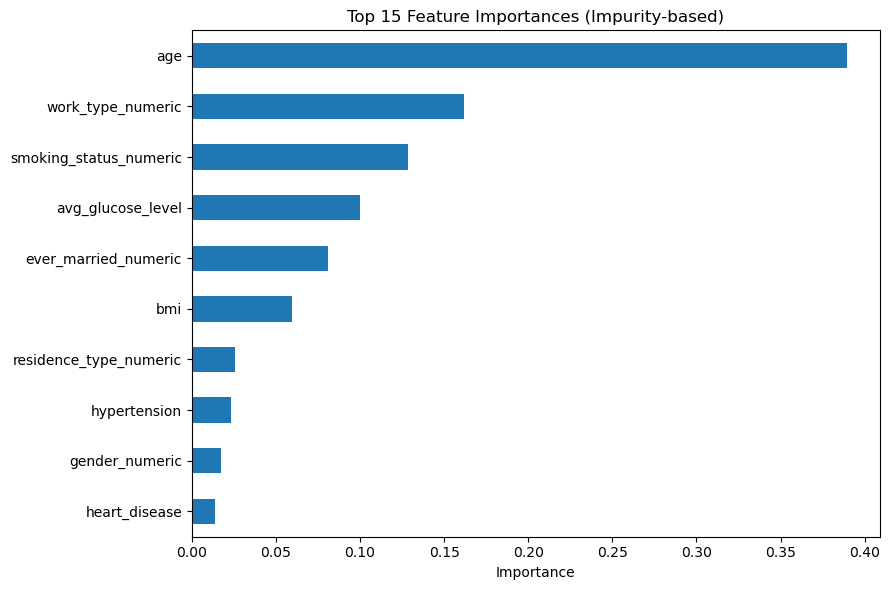

In [144]:
features = dfv2.drop(columns = ["stroke"])
target = dfv2["stroke"]

X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_lg)

X_train_norm_lg = normalizer.transform(X_train_lg)
X_test_norm_lg = normalizer.transform(X_test_lg)

X_train_norm_lg = pd.DataFrame(X_train_norm_lg, columns = X_train_lg.columns)
X_test_norm_lg = pd.DataFrame(X_test_norm_lg, columns = X_test_lg.columns)

# — Assume `model` is already trained, and X_train is defined —

# 1. Extract the raw importances
importances = model_rf01.feature_importances_

# 2. Create a pandas Series (index = feature names), sorted descending
feat_importance = pd.Series(importances, index=X_train_lg.columns).sort_values(ascending=False)

# 3. Plot the top 15
plt.figure(figsize=(9, 6))
feat_importance.plot(kind='barh')
plt.title("Top 15 Feature Importances (Impurity-based)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [145]:
# 1. Define your base pipeline (with placeholders for hyper-params)
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(solver='liblinear', random_state=42),
        method='sigmoid',
        cv=3
    ))
])

# 2. Specify the grid of parameters to search
param_grid = {
    # Try different minority over-sampling ratios
    'smote__sampling_strategy': [0.1, 0.3, 0.5],
    
    # Regularization strength: small C = strong regularization, large C = weak
    'calibrated_lr__estimator__C': [0.01, 0.1, 1, 10],
    
    # Penalty: L1 for sparse (feature selection), L2 for ridge-style shrinkage
    'calibrated_lr__estimator__penalty': ['l1', 'l2']
}

# 3. Set up GridSearchCV (outer 5-fold CV) using AUC as scoring for imbalanced data
model_lg_threshold20_01 = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# 4. Fit on your training data
model_lg_threshold20_01.fit(X_train_norm_lg, y_train_lg)

# 5. Inspect best params
print("Best parameters found:")
print(model_lg_threshold20_01.best_params_)

# 6. Use the best‐found estimator to predict on test set
best_model = model_lg_threshold20_01.best_estimator_
y_prob = best_model.predict_proba(X_test_norm_lg)[:, 1]
y_pred_custom = (y_prob >= 0.20).astype(int)

# 7. Evaluate
print_all_metrics(
    y_true=y_test_lg,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:
{'calibrated_lr__estimator__C': 0.01, 'calibrated_lr__estimator__penalty': 'l1', 'smote__sampling_strategy': 0.5}
Accuracy: 0.595

Classification report:

              precision    recall  f1-score   support

           0      0.996     0.578     0.732       939
           1      0.094     0.953     0.171        43

    accuracy                          0.595       982
   macro avg      0.545     0.766     0.451       982
weighted avg      0.957     0.595     0.707       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 543,  FP = 396
    FN = 2,  TP = 41

Sensitivity (Recall₁) = 0.953
Specificity (Recall₀) = 0.578

Precision (PPV)₁ = 0.094
Recall (Sensitivity)₁ = 0.953
F1-score₁       = 0.171

ROC AUC (pos_label=1) = 0.852


 Logistc Regression - For Insurance Company

In [146]:
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_lg)

X_train_norm_lg = normalizer.transform(X_train_lg)
X_test_norm_lg = normalizer.transform(X_test_lg)

X_train_norm_lg = pd.DataFrame(X_train_norm_lg, columns = X_train_lg.columns)
X_test_norm_lg = pd.DataFrame(X_test_norm_lg, columns = X_test_lg.columns)

In [147]:
"""
# ————————————————
# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression
# ————————————————
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(
            class_weight='balanced',
            solver='liblinear',
            random_state=42
        ),
        method='sigmoid',
        cv=3  # internal CV for calibration
    ))
])

# ————————————————
# 2) Define the param_grid
#    (Still tuning sampling_strategy, C and penalty on the wrapped LR)
# ————————————————
param_grid_logreg_pipe = {
    'smote__sampling_strategy': [0.3, 0.7, 1.0],
    'calibrated_lr__estimator__C': [0.01, 0.1, 1.0, 10.0],
    'calibrated_lr__estimator__penalty': ['l1', 'l2']
}

# ————————————————
# 3) Run the grid search on the original (un-resampled) data
# ————————————————
grid_search_log_treshold50 = grid_search_with_progress(
    pipe,
    param_grid_logreg_pipe,
    X_train_norm_lg,  # your normalized training features
    y_train_lg,       # your original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Grab the best‐found pipeline
model_lg_treshold50 = grid_search_log_treshold50.best_estimator_

# ————————————————
# 4) Make calibrated probability predictions on the test set
# ————————————————
y_prob = model_lg_treshold50.predict_proba(X_test_norm_lg)[:, 1]  # probability of class “1” (stroke)

# ————————————————
# 5) Choose your threshold here:
#    (Set THRESHOLD = any value in [0,1])
# ————————————————
THRESHOLD = 0.50

# Convert probabilities to class labels using your chosen threshold:
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate all metrics at this threshold
# ————————————————
# Confusion matrix (tn, fp, fn, tp)
tn, fp, fn, tp = confusion_matrix(y_test_lg, y_pred_custom).ravel()

print(f"\n=== Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")

print_all_metrics(
    y_true=y_test_lg,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)
"""


'\n# ————————————————\n# 1) Build the pipeline: SMOTE → Calibrated Logistic Regression\n# ————————————————\npipe = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_lr\', CalibratedClassifierCV(\n        estimator=LogisticRegression(\n            class_weight=\'balanced\',\n            solver=\'liblinear\',\n            random_state=42\n        ),\n        method=\'sigmoid\',\n        cv=3  # internal CV for calibration\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    (Still tuning sampling_strategy, C and penalty on the wrapped LR)\n# ————————————————\nparam_grid_logreg_pipe = {\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n    \'calibrated_lr__estimator__C\': [0.01, 0.1, 1.0, 10.0],\n    \'calibrated_lr__estimator__penalty\': [\'l1\', \'l2\']\n}\n\n# ————————————————\n# 3) Run the grid search on the original (un-resampled) data\n# ————————————————\ngrid_search_log_treshold50 = grid_search_with_progress(\n    pipe,\n    param_grid_logreg

In [148]:
#grid_search_log_params_treshold50 = grid_search_log_treshold50.best_params_
#display(grid_search_log_params_treshold50)
"""
{'calibrated_lr__estimator__C': 0.1,
 'calibrated_lr__estimator__penalty': 'l1',
 'smote__sampling_strategy': 0.3}

"""

"\n{'calibrated_lr__estimator__C': 0.1,\n 'calibrated_lr__estimator__penalty': 'l1',\n 'smote__sampling_strategy': 0.3}\n\n"

In [149]:
# Define pipeline with Logistic Regression and specified parameters
model_lg_threshold50 = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('calibrated_lr', CalibratedClassifierCV(
        estimator=LogisticRegression(
            C=0.1,
            penalty='l1',
            solver='liblinear',  # Required for 'l1' penalty
            random_state=42
        ),
        method='sigmoid',
        cv=3
    ))
])

# Fit the pipeline
model_lg_threshold50.fit(X_train_norm_lg, y_train_lg)

# Predict probabilities
y_prob = model_lg_threshold50.predict_proba(X_test_norm_lg)[:, 1]

# Apply custom threshold
THRESHOLD = 0.50
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

# Evaluate
print_all_metrics(
    y_true=y_test_lg,
    y_pred=y_pred_custom,
    y_prob=y_prob,
    positive_label=1
)

Accuracy: 0.888

Classification report:

              precision    recall  f1-score   support

           0      0.976     0.905     0.939       939
           1      0.198     0.512     0.286        43

    accuracy                          0.888       982
   macro avg      0.587     0.708     0.612       982
weighted avg      0.942     0.888     0.911       982

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 850,  FP = 89
    FN = 21,  TP = 22

Sensitivity (Recall₁) = 0.512
Specificity (Recall₀) = 0.905

Precision (PPV)₁ = 0.198
Recall (Sensitivity)₁ = 0.512
F1-score₁       = 0.286

ROC AUC (pos_label=1) = 0.849


In [150]:
# do the same for other models.(gradient boosting lightgbm, catboost) check what makes sense for the data.

#### Gradient Boosting

In [151]:
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_gb)

X_train_norm_gb = normalizer.transform(X_train_gb)
X_test_norm_gb = normalizer.transform(X_test_gb)

X_train_norm_gb = pd.DataFrame(X_train_norm_gb, columns = X_train_gb.columns)
X_test_norm_gb = pd.DataFrame(X_test_norm_gb, columns = X_test_lg.columns)

In [152]:
"""
# ————————————————
# 1) Build the pipeline: SMOTE → Calibrated GradientBoosting
# ————————————————
pipe_gb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_gb', CalibratedClassifierCV(
        estimator=GradientBoostingClassifier(random_state=42),
        method='sigmoid',
        cv=3
    ))
])

# ————————————————
# 2) Define the param_grid
#    Tune both sampling_strategy and GB hyperparameters
# ————————————————
param_grid_gb_pipe = {
    # SMOTE: fraction of minority after resampling
    'smote__sampling_strategy': [0.3, 0.7, 1.0],

    # GB learner params (inside the calibrated wrapper)
    'calibrated_gb__estimator__n_estimators': [50, 100, 200],
    'calibrated_gb__estimator__learning_rate': [0.01, 0.1, 0.2],
    'calibrated_gb__estimator__max_depth': [3, 5, 7],
    'calibrated_gb__estimator__subsample': [0.6, 0.8, 1.0]
}

# ————————————————
# 3) Run the grid search on the original (un‐resampled) data
# ————————————————
grid_search_gb = grid_search_with_progress(
    pipe_gb,
    param_grid_gb_pipe,
    X_train_norm_gb,  # your normalized training features
    y_train_gb,       # your original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Best‐found pipeline
model_gb_treshold20 = grid_search_gb.best_estimator_

# ————————————————
# 4) Get calibrated probabilities on test set
# ————————————————
y_prob_gb = model_gb_treshold20.predict_proba(X_test_norm_gb)[:, 1]

# ————————————————
# 5) Thresholding
# ————————————————
THRESHOLD = 0.20
y_pred_gb = (y_prob_gb >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate metrics
# ————————————————
tn, fp, fn, tp = confusion_matrix(y_test_gb, y_pred_gb).ravel()

print(f"\n=== GradientBoosting Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")
print_all_metrics(
    y_true=y_test_gb,
    y_pred=y_pred_gb,
    y_prob=y_prob_gb,
    positive_label=1
)
"""

'\n# ————————————————\n# 1) Build the pipeline: SMOTE → Calibrated GradientBoosting\n# ————————————————\npipe_gb = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_gb\', CalibratedClassifierCV(\n        estimator=GradientBoostingClassifier(random_state=42),\n        method=\'sigmoid\',\n        cv=3\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    Tune both sampling_strategy and GB hyperparameters\n# ————————————————\nparam_grid_gb_pipe = {\n    # SMOTE: fraction of minority after resampling\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n\n    # GB learner params (inside the calibrated wrapper)\n    \'calibrated_gb__estimator__n_estimators\': [50, 100, 200],\n    \'calibrated_gb__estimator__learning_rate\': [0.01, 0.1, 0.2],\n    \'calibrated_gb__estimator__max_depth\': [3, 5, 7],\n    \'calibrated_gb__estimator__subsample\': [0.6, 0.8, 1.0]\n}\n\n# ————————————————\n# 3) Run the grid search on the original (un‐resampled) data\n# ————————

In [153]:
#grid_search_gb.best_params_

"""
{'calibrated_gb__estimator__learning_rate': 0.01,
 'calibrated_gb__estimator__max_depth': 5,
 'calibrated_gb__estimator__n_estimators': 200,
 'calibrated_gb__estimator__subsample': 0.6,
 'smote__sampling_strategy': 0.7}
 """

"\n{'calibrated_gb__estimator__learning_rate': 0.01,\n 'calibrated_gb__estimator__max_depth': 5,\n 'calibrated_gb__estimator__n_estimators': 200,\n 'calibrated_gb__estimator__subsample': 0.6,\n 'smote__sampling_strategy': 0.7}\n "

#### LightGBM

In [154]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_lgbm)

X_train_norm_lgbm = normalizer.transform(X_train_lgbm)
X_test_norm_lgbm = normalizer.transform(X_test_lgbm)

X_train_norm_lgbm = pd.DataFrame(X_train_norm_lgbm, columns = X_train_lgbm.columns)
X_test_norm_lgbm = pd.DataFrame(X_test_norm_lgbm, columns = X_test_lgbm.columns)

In [155]:
"""
# ————————————————
# 1) Build the pipeline: SMOTE → Calibrated LGBM
# ————————————————
pipe_lgbm = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_lgb', CalibratedClassifierCV(
        estimator=LGBMClassifier(random_state=42),
        method='sigmoid',
        cv=3
    ))
])

# ————————————————
# 2) Define the param_grid
#    Tune both sampling_strategy and LightGBM hyperparameters
# ————————————————
param_grid_lgbm_pipe = {
    # SMOTE: fraction of minority after resampling
    'smote__sampling_strategy': [0.3, 0.7, 1.0],

    # LGBM params (inside the calibrated wrapper)
    'calibrated_lgb__estimator__n_estimators': [50, 100, 200],
    'calibrated_lgb__estimator__learning_rate': [0.01, 0.1, 0.2],
    'calibrated_lgb__estimator__max_depth': [3, 5, 7],
    'calibrated_lgb__estimator__subsample': [0.6, 0.8, 1.0],
    # you can also tune e.g. 'colsample_bytree' or 'min_child_samples' if desired
    # 'calibrated_lgb__estimator__colsample_bytree': [0.6, 0.8, 1.0],
    # 'calibrated_lgb__estimator__min_child_samples': [10, 20, 30],
}

# ————————————————
# 3) Run the grid search on the original (un‐resampled) data
# ————————————————
grid_search_lgbm = grid_search_with_progress(
    pipe_lgbm,
    param_grid_lgbm_pipe,
    X_train_norm_gb,  # your normalized training features
    y_train_gb,       # your original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Best‐found pipeline
model_lgbm_threshold20 = grid_search_lgbm.best_estimator_

# ————————————————
# 4) Get calibrated probabilities on test set
# ————————————————
y_prob_lgbm = model_lgbm_threshold20.predict_proba(X_test_norm_lgbm)[:, 1]

# ————————————————
# 5) Thresholding
# ————————————————
THRESHOLD = 0.20
y_pred_lgbm = (y_prob_lgbm >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate metrics
# ————————————————

print(f"\n=== LightGBM Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")
print_all_metrics(
    y_true=y_test_lgbm,
    y_pred=y_pred_lgbm,
    y_prob=y_prob_lgbm,
    positive_label=1
)
"""

'\n# ————————————————\n# 1) Build the pipeline: SMOTE → Calibrated LGBM\n# ————————————————\npipe_lgbm = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_lgb\', CalibratedClassifierCV(\n        estimator=LGBMClassifier(random_state=42),\n        method=\'sigmoid\',\n        cv=3\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    Tune both sampling_strategy and LightGBM hyperparameters\n# ————————————————\nparam_grid_lgbm_pipe = {\n    # SMOTE: fraction of minority after resampling\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n\n    # LGBM params (inside the calibrated wrapper)\n    \'calibrated_lgb__estimator__n_estimators\': [50, 100, 200],\n    \'calibrated_lgb__estimator__learning_rate\': [0.01, 0.1, 0.2],\n    \'calibrated_lgb__estimator__max_depth\': [3, 5, 7],\n    \'calibrated_lgb__estimator__subsample\': [0.6, 0.8, 1.0],\n    # you can also tune e.g. \'colsample_bytree\' or \'min_child_samples\' if desired\n    # \'calibrated_lgb__

In [156]:
#grid_search_lgbm.best_params_
"""
{'calibrated_lgb__estimator__learning_rate': 0.01,
 'calibrated_lgb__estimator__max_depth': 5,
 'calibrated_lgb__estimator__n_estimators': 200,
 'calibrated_lgb__estimator__subsample': 0.6,
 'smote__sampling_strategy': 0.7}

 """

"\n{'calibrated_lgb__estimator__learning_rate': 0.01,\n 'calibrated_lgb__estimator__max_depth': 5,\n 'calibrated_lgb__estimator__n_estimators': 200,\n 'calibrated_lgb__estimator__subsample': 0.6,\n 'smote__sampling_strategy': 0.7}\n\n "

#### Cat Boost

In [157]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_cb)

X_train_norm_cb = normalizer.transform(X_train_cb)
X_test_norm_cb = normalizer.transform(X_test_cb)

X_train_norm_cb = pd.DataFrame(X_train_norm_cb, columns = X_train_cb.columns)
X_test_norm_cb = pd.DataFrame(X_test_norm_cb, columns = X_test_cb.columns)

In [158]:
"""
# ————————————————
# 1) Build the pipeline: SMOTE → Calibrated CatBoost
# ————————————————
pipe_cb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('calibrated_cb', CalibratedClassifierCV(
        estimator=CatBoostClassifier(
            random_seed=42,
            verbose=False          # suppress CatBoost logging
        ),
        method='sigmoid',
        cv=3
    ))
])

# ————————————————
# 2) Define the param_grid
#    Tune both sampling_strategy and CatBoost hyperparameters
# ————————————————
param_grid_cb_pipe = {
    # SMOTE: fraction of minority after resampling
    'smote__sampling_strategy': [0.3, 0.7, 1.0],

    # CatBoost params (inside the calibrated wrapper)
    'calibrated_cb__estimator__iterations': [50, 100, 200],
    'calibrated_cb__estimator__learning_rate': [0.01, 0.1, 0.2],
    'calibrated_cb__estimator__depth': [3, 5, 7],
    'calibrated_cb__estimator__subsample': [0.6, 0.8, 1.0],
    # you might also tune:
    # 'calibrated_cb__estimator__l2_leaf_reg': [1, 3, 5],
    # 'calibrated_cb__estimator__bagging_temperature': [0.0, 0.5, 1.0],
}

# ————————————————
# 3) Run the grid search on the original (un‐resampled) data
# ————————————————
grid_search_cb = grid_search_with_progress(
    pipe_cb,
    param_grid_cb_pipe,
    X_train_norm_gb,  # your normalized training features
    y_train_gb,       # your original training labels
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Best‐found pipeline
model_cb_threshold20 = grid_search_cb.best_estimator_

# ————————————————
# 4) Get calibrated probabilities on test set
# ————————————————
y_prob_cb = model_cb_threshold20.predict_proba(X_test_norm_cb)[:, 1]

# ————————————————
# 5) Thresholding
# ————————————————
THRESHOLD = 0.20
y_pred_cb = (y_prob_cb >= THRESHOLD).astype(int)

# ————————————————
# 6) Compute/Evaluate metrics
# ————————————————

print(f"\n=== CatBoost Metrics at THRESHOLD = {THRESHOLD:.2f} ===\n")
print_all_metrics(
    y_true=y_test_cb,
    y_pred=y_pred_cb,
    y_prob=y_prob_cb,
    positive_label=1
)
"""

'\n# ————————————————\n# 1) Build the pipeline: SMOTE → Calibrated CatBoost\n# ————————————————\npipe_cb = Pipeline([\n    (\'smote\', SMOTE(random_state=42)),\n    (\'calibrated_cb\', CalibratedClassifierCV(\n        estimator=CatBoostClassifier(\n            random_seed=42,\n            verbose=False          # suppress CatBoost logging\n        ),\n        method=\'sigmoid\',\n        cv=3\n    ))\n])\n\n# ————————————————\n# 2) Define the param_grid\n#    Tune both sampling_strategy and CatBoost hyperparameters\n# ————————————————\nparam_grid_cb_pipe = {\n    # SMOTE: fraction of minority after resampling\n    \'smote__sampling_strategy\': [0.3, 0.7, 1.0],\n\n    # CatBoost params (inside the calibrated wrapper)\n    \'calibrated_cb__estimator__iterations\': [50, 100, 200],\n    \'calibrated_cb__estimator__learning_rate\': [0.01, 0.1, 0.2],\n    \'calibrated_cb__estimator__depth\': [3, 5, 7],\n    \'calibrated_cb__estimator__subsample\': [0.6, 0.8, 1.0],\n    # you might also tune:

In [159]:
#grid_search_cb.best_params_

"""
{'calibrated_cb__estimator__depth': 3,
 'calibrated_cb__estimator__iterations': 50,
 'calibrated_cb__estimator__learning_rate': 0.01,
 'calibrated_cb__estimator__subsample': 0.6,
 'smote__sampling_strategy': 0.3}
 
"""


"\n{'calibrated_cb__estimator__depth': 3,\n 'calibrated_cb__estimator__iterations': 50,\n 'calibrated_cb__estimator__learning_rate': 0.01,\n 'calibrated_cb__estimator__subsample': 0.6,\n 'smote__sampling_strategy': 0.3}\n \n"

#### Meta - Ensemble

In [160]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train_meta)

X_train_norm_meta = normalizer.transform(X_train_meta)
X_test_norm_meta = normalizer.transform(X_test_meta)

X_train_norm_meta = pd.DataFrame(X_train_norm_meta, columns = X_train_meta.columns)
X_test_norm_meta = pd.DataFrame(X_test_norm_meta, columns = X_test_meta.columns)

In [161]:

def setup_logging(level: int = logging.INFO) -> None:
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        level=level,
    )


def time_run(label: str, func: Any, *args, **kwargs) -> Any:
    start = time.perf_counter()
    result = func(*args, **kwargs)
    elapsed = time.perf_counter() - start
    logging.info("[%s] completed in %.2f seconds", label, elapsed)
    return result

@dataclass
class ModelConfig:
    name: str
    pipeline: Pipeline
    cv_score: Optional[float] = field(default=None)
    threshold: float = field(default=0.5)


def create_pipeline(estimator, sampler_strategy: Optional[float] = None, random_state: int = 42) -> Pipeline:
    steps = []
    if sampler_strategy is not None:
        steps.append(('smote', SMOTE(sampling_strategy=sampler_strategy, random_state=random_state)))
    steps.append(('model', estimator))
    return Pipeline(steps)


def get_models(sampling_strategy: float) -> List[ModelConfig]:
    base_estimators = [
        LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42),
        RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt',
                               class_weight='balanced_subsample', random_state=42),
        LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6, random_state=42),
        CatBoostClassifier(depth=3, iterations=50, learning_rate=0.01, subsample=0.6,
                           verbose=False, random_seed=42),
        GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200,
                                   subsample=0.6, random_state=42),
    ]

    configs: List[ModelConfig] = []
    for est in base_estimators:
        name = est.__class__.__name__.lower()
        configs.append(ModelConfig(name=name, pipeline=create_pipeline(est, sampling_strategy)))

    stack_steps = [(cfg.name, clone(cfg.pipeline)) for cfg in configs]
    stack_estimator = StackingClassifier(
        estimators=stack_steps,
        final_estimator=LogisticRegression(solver='liblinear', random_state=42),
        passthrough=True,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )
    configs.append(ModelConfig(name='stacking', pipeline=create_pipeline(stack_estimator, sampler_strategy=None)))
    return configs


results_store: List[Dict[str, Any]] = []  # Global store


def store_results(model_name, sampling_strategy, y_test, y_pred, y_prob, cv_score):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results_store.append({
        'model': model_name,
        'smote_strategy': sampling_strategy,
        'cv_auc': round(cv_score, 4),
        'test_auc': round(roc_auc_score(y_test, y_prob), 4),
        'precision': round(precision_score(y_test, y_pred), 4),
        'recall': round(recall_score(y_test, y_pred), 4),
        'f1': round(f1_score(y_test, y_pred), 4),
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })


def evaluate_model(config: ModelConfig, X_train, y_train, X_test, y_test, sampling_strategy: float) -> None:
    logging.info("--- %s ---", config.name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    config.cv_score = np.mean(cross_val_score(config.pipeline, X_train, y_train,
                                              cv=cv, scoring='roc_auc', n_jobs=-1, error_score='raise'))
    logging.info("CV ROC AUC: %.4f", config.cv_score)

    time_run(f"fit_{config.name}", config.pipeline.fit, X_train, y_train)

    y_prob = config.pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= config.threshold).astype(int)

    test_auc = roc_auc_score(y_test, y_prob)
    logging.info("Test ROC AUC: %.4f", test_auc)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, digits=4))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    logging.info("Confusion matrix: TN=%d, FP=%d, FN=%d, TP=%d", tn, fp, fn, tp)

    store_results(config.name, sampling_strategy, y_test, y_pred, y_prob, config.cv_score)


def main(X: pd.DataFrame, y: pd.Series,
         test_size: float = 0.2,
         random_state: int = 42,
         sampling_strategies: List[float] = [0.3, 0.5, 0.7]) -> None:
    setup_logging()
    logging.info("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=y, random_state=random_state)

    for strat in sampling_strategies:
        logging.info("Running SMOTE(%s)", strat)
        for cfg in get_models(sampling_strategy=strat):
            evaluate_model(cfg, X_train, y_train, X_test, y_test, sampling_strategy=strat)

    df_results = pd.DataFrame(results_store)
    logging.info("Final results summary:\n%s", df_results)
    df_results.to_csv("model_evaluation_results.csv", index=False)
    logging.info("Pipeline complete. Results saved to model_evaluation_results.csv")


if __name__ == "__main__":
    from sklearn.datasets import make_classification

    X_arr, y_arr = make_classification(
        n_samples=5000,
        n_features=20,
        weights=[0.9, 0.1],
        flip_y=0.01,
        random_state=42
    )
    X = pd.DataFrame(X_arr)
    y = pd.Series(y_arr)

    main(X, y)
   

2025-06-10 14:42:41 - INFO - Splitting data...
2025-06-10 14:42:41 - INFO - Running SMOTE(0.3)
2025-06-10 14:42:41 - INFO - --- logisticregression ---
2025-06-10 14:42:41 - INFO - CV ROC AUC: 0.9130
2025-06-10 14:42:41 - INFO - [fit_logisticregression] completed in 0.07 seconds
2025-06-10 14:42:41 - INFO - Test ROC AUC: 0.9301
2025-06-10 14:42:41 - INFO - Classification report:
              precision    recall  f1-score   support

           0     0.9647    0.9464    0.9554       895
           1     0.6066    0.7048    0.6520       105

    accuracy                         0.9210      1000
   macro avg     0.7856    0.8256    0.8037      1000
weighted avg     0.9271    0.9210    0.9236      1000

2025-06-10 14:42:41 - INFO - Confusion matrix: TN=847, FP=48, FN=31, TP=74
2025-06-10 14:42:41 - INFO - --- randomforestclassifier ---
2025-06-10 14:42:43 - INFO - CV ROC AUC: 0.9303
2025-06-10 14:42:44 - INFO - [fit_randomforestclassifier] completed in 1.70 seconds
2025-06-10 14:42:44 - INF

[LightGBM] [Info] Number of positive: 1074, number of negative: 3582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4656, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230670 -> initscore=-1.204531
[LightGBM] [Info] Start training from score -1.204531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2025-06-10 14:42:48 - INFO - CV ROC AUC: 0.9233
2025-06-10 14:42:48 - INFO - [fit_catboostclassifier] completed in 0.32 seconds
2025-06-10 14:42:48 - INFO - Test ROC AUC: 0.9358
2025-06-10 14:42:48 - INFO - Classification report:
              precision    recall  f1-score   support

           0     0.9678    0.9408    0.9541       895
           1     0.5923    0.7333    0.6553       105

    accuracy                         0.9190      1000
   macro avg     0.7801    0.8371    0.8047      1000
weighted avg     0.9284    0.9190    0.9227      1000

2025-06-10 14:42:48 - INFO - Confusion matrix: TN=842, FP=53, FN=28, TP=77
2025-06-10 14:42:48 - INFO - --- gradientboostingclassifier ---
2025-06-10 14:42:55 - INFO - CV ROC AUC: 0.9326
2025-06-10 14:43:02 - INFO - [fit_gradientboostingclassifier] completed in 6.83 seconds
2025-06-10 14:43:02 - INFO - Test ROC AUC: 0.9425
2025-06-10 14:43:02 - INFO - Classification report:
              precision    recall  f1-score   support

           

[LightGBM] [Info] Number of positive: 1791, number of negative: 3582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5373, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2025-06-10 14:44:47 - INFO - CV ROC AUC: 0.9262
2025-06-10 14:44:48 - INFO - [fit_catboostclassifier] completed in 0.24 seconds
2025-06-10 14:44:48 - INFO - Test ROC AUC: 0.9364
2025-06-10 14:44:48 - INFO - Classification report:
              precision    recall  f1-score   support

           0     0.9724    0.9061    0.9381       895
           1     0.4940    0.7810    0.6052       105

    accuracy                         0.8930      1000
   macro avg     0.7332    0.8435    0.7716      1000
weighted avg     0.9222    0.8930    0.9032      1000

2025-06-10 14:44:48 - INFO - Confusion matrix: TN=811, FP=84, FN=23, TP=82
2025-06-10 14:44:48 - INFO - --- gradientboostingclassifier ---
2025-06-10 14:44:55 - INFO - CV ROC AUC: 0.9293
2025-06-10 14:45:04 - INFO - [fit_gradientboostingclassifier] completed in 8.62 seconds
2025-06-10 14:45:04 - INFO - Test ROC AUC: 0.9392
2025-06-10 14:45:04 - INFO - Classification report:
              precision    recall  f1-score   support

           

[LightGBM] [Info] Number of positive: 2507, number of negative: 3582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 6089, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411726 -> initscore=-0.356834
[LightGBM] [Info] Start training from score -0.356834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2025-06-10 14:46:23 - INFO - CV ROC AUC: 0.9263
2025-06-10 14:46:24 - INFO - [fit_catboostclassifier] completed in 0.24 seconds
2025-06-10 14:46:24 - INFO - Test ROC AUC: 0.9393
2025-06-10 14:46:24 - INFO - Classification report:
              precision    recall  f1-score   support

           0     0.9756    0.8927    0.9323       895
           1     0.4696    0.8095    0.5944       105

    accuracy                         0.8840      1000
   macro avg     0.7226    0.8511    0.7634      1000
weighted avg     0.9225    0.8840    0.8968      1000

2025-06-10 14:46:24 - INFO - Confusion matrix: TN=799, FP=96, FN=20, TP=85
2025-06-10 14:46:24 - INFO - --- gradientboostingclassifier ---
2025-06-10 14:46:33 - INFO - CV ROC AUC: 0.9303
2025-06-10 14:46:43 - INFO - [fit_gradientboostingclassifier] completed in 10.46 seconds
2025-06-10 14:46:43 - INFO - Test ROC AUC: 0.9369
2025-06-10 14:46:43 - INFO - Classification report:
              precision    recall  f1-score   support

          

C:\Users\estif\AppData\Local\Temp\ipykernel_17028\1391910398.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(



=== Model Performance Summary ===
                        model  smote_strategy  cv_auc  test_auc  precision  \
0          logisticregression             0.7  0.9123    0.9285     0.4599   
1          catboostclassifier             0.7  0.9263    0.9393     0.4696   
2      randomforestclassifier             0.7  0.9258    0.9368     0.6364   
3      randomforestclassifier             0.5  0.9264    0.9384     0.6720   
4              lgbmclassifier             0.5  0.9274    0.9337     0.7757   
5  gradientboostingclassifier             0.5  0.9293    0.9392     0.7685   
6              lgbmclassifier             0.7  0.9280    0.9289     0.7281   
7          catboostclassifier             0.5  0.9262    0.9364     0.4940   
8  gradientboostingclassifier             0.7  0.9303    0.9369     0.6777   
9              lgbmclassifier             0.3  0.9329    0.9348     0.8020   

   recall      f1  TP   FP   TN  FN  
0  0.8190  0.5890  86  101  794  19  
1  0.8095  0.5944  85   96  79

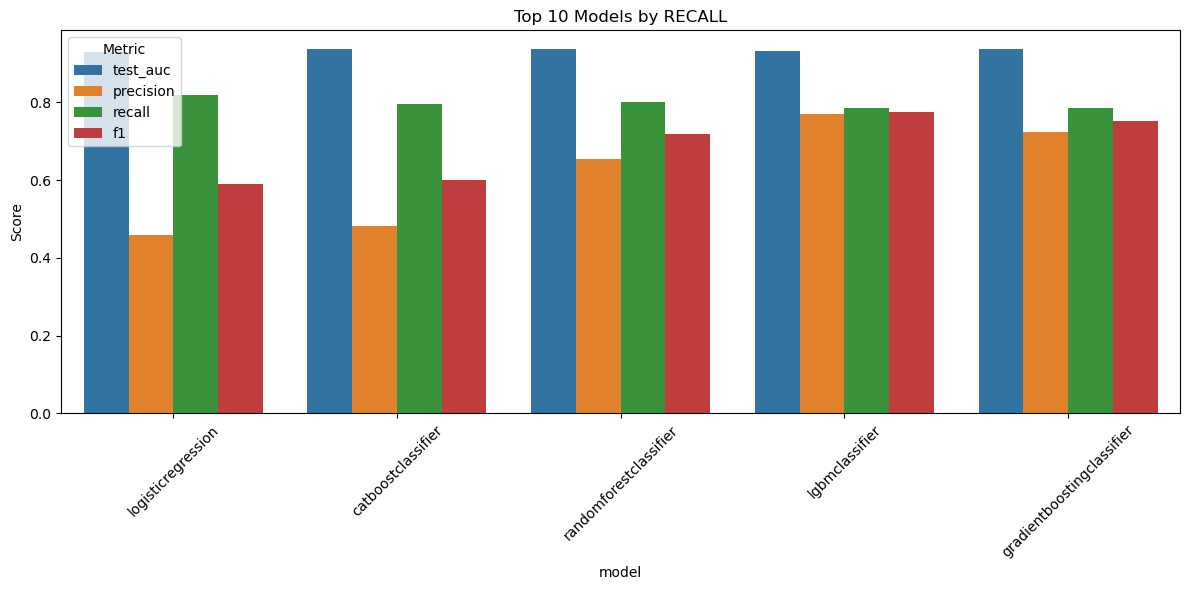

In [162]:
def analyze_all_models(results_df: pd.DataFrame, sort_by: str = "test_auc", top_n: Optional[int] = None, show_plots: bool = True):
    """
    Analyze and compare all evaluated models using the results DataFrame.

    Parameters:
        results_df (pd.DataFrame): The results collected by `store_results()`.
        sort_by (str): Metric to sort by (e.g., 'test_auc', 'f1', 'recall').
        top_n (int, optional): Show only top N models.
        show_plots (bool): Whether to plot metric comparisons.
    """
    print("\n=== Model Performance Summary ===")
    summary = results_df.sort_values(by=sort_by, ascending=False).reset_index(drop=True)
    if top_n:
        summary = summary.head(top_n)
    print(summary)

    if show_plots:
        metrics_to_plot = ["test_auc", "precision", "recall", "f1"]
        melted = pd.melt(summary, id_vars=["model", "smote_strategy"], value_vars=metrics_to_plot)

        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=melted,
            x="model",
            y="value",
            hue="variable",
            ci=None
        )
        plt.title(f"Top {top_n if top_n else 'All'} Models by {sort_by.upper()}")
        plt.ylabel("Score")
        plt.xticks(rotation=45)
        plt.legend(title="Metric")
        plt.tight_layout()
        plt.show()

# Example usage (you can remove this part and keep it in a separate script or notebook if preferred):
if __name__ == "__main__":
    df_results = pd.read_csv("model_evaluation_results.csv")
    analyze_all_models(df_results, sort_by="recall", top_n=10)

In [163]:
df_results

,model,smote_strategy,cv_auc,test_auc,precision,recall,f1,TP,FP,TN,FN
0,logisticregression,0.3,0.9130,0.9301,0.6066,0.7048,0.6520,74,48,847,31
1,randomforestclassifier,0.3,0.9303,0.9372,0.7207,0.7619,0.7407,80,31,864,25
2,lgbmclassifier,0.3,0.9329,0.9348,0.8020,0.7714,0.7864,81,20,875,24
3,catboostclassifier,0.3,0.9233,0.9358,0.5923,0.7333,0.6553,77,53,842,28
4,gradientboostingclassifier,0.3,0.9326,0.9425,0.8247,0.7619,0.7921,80,17,878,25
5,stacking,0.3,0.9341,0.9410,0.8191,0.7333,0.7739,77,17,878,28
6,logisticregression,0.5,0.9127,0.9290,0.5031,0.7714,0.6090,81,80,815,24
7,randomforestclassifier,0.5,0.9264,0.9384,0.6720,0.8000,0.7304,84,41,854,21
8,lgbmclassifier,0.5,0.9274,0.9337,0.7757,0.7905,0.7830,83,24,871,22
9,catboostclassifier,0.5,0.9262,0.9364,0.4940,0.7810,0.6052,82,84,811,23


In [164]:

best = df_results.sort_values("recall", ascending=False).iloc[0]
best_name   = best["model"]
best_smote  = best["smote_strategy"]
print(f"Best = {best_name!r} with SMOTE={best_smote}")

# --- 2) re-instantiate just that one ModelConfig ---
configs = get_models(sampling_strategy=best_smote)
best_cfg = next(cfg for cfg in configs if cfg.name == best_name)

# --- 3) fit it (if you haven’t already) ---
best_cfg.pipeline.fit(X_train_norm_meta, y_train_meta)

# --- 4) pull out the “model” step and inspect its params ---
model_step = best_cfg.pipeline.named_steps["model"]

# this gives you a flat dict of all hyper-parameters:
best_params = model_step.get_params()
print("Hyperparameters of the best model:")
for k, v in best_params.items():
    print(f" • {k} = {v}")



Best = 'logisticregression' with SMOTE=0.7
Hyperparameters of the best model:
 • C = 0.1
 • class_weight = None
 • dual = False
 • fit_intercept = True
 • intercept_scaling = 1
 • l1_ratio = None
 • max_iter = 100
 • multi_class = auto
 • n_jobs = None
 • penalty = l1
 • random_state = 42
 • solver = liblinear
 • tol = 0.0001
 • verbose = 0
 • warm_start = False


In [165]:
"""
Best = 'logisticregression' with SMOTE=0.7
Hyperparameters of the best model:
 • C = 0.1
 • class_weight = None
 • dual = False
 • fit_intercept = True
 • intercept_scaling = 1
 • l1_ratio = None
 • max_iter = 100
 • multi_class = auto
 • n_jobs = None
 • penalty = l1
 • random_state = 42
 • solver = liblinear
 • tol = 0.0001
 • verbose = 0
 • warm_start = False
 
 """

"\nBest = 'logisticregression' with SMOTE=0.7\nHyperparameters of the best model:\n • C = 0.1\n • class_weight = None\n • dual = False\n • fit_intercept = True\n • intercept_scaling = 1\n • l1_ratio = None\n • max_iter = 100\n • multi_class = auto\n • n_jobs = None\n • penalty = l1\n • random_state = 42\n • solver = liblinear\n • tol = 0.0001\n • verbose = 0\n • warm_start = False\n \n "

In [166]:
best_cfg

ModelConfig(name='logisticregression', pipeline=Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('model',
                 LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                    solver='liblinear'))]), cv_score=None, threshold=0.5)

#### Logist Regression BEST MODEL

In [167]:

# Use same data and split as original
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Rebuild the best pipeline
best_lg = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.7, random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])

# Fit and predict
best_lg.fit(X_train_lg, y_train_lg)
y_prob = best_lg.predict_proba(X_test_lg)[:, 1]

# Use same threshold as original run
THRESHOLD = 0.5
y_pred = (y_prob >= THRESHOLD).astype(int)

print_all_metrics(y_test_lg, y_pred, y_prob)

Accuracy: 0.880

Classification report:

              precision    recall  f1-score   support

           0      0.977     0.887     0.930       895
           1      0.460     0.819     0.589       105

    accuracy                          0.880      1000
   macro avg      0.718     0.853     0.759      1000
weighted avg      0.922     0.880     0.894      1000

Confusion matrix (true_neg, false_pos, false_neg, true_pos):
    TN = 794,  FP = 101
    FN = 19,  TP = 86

Sensitivity (Recall₁) = 0.819
Specificity (Recall₀) = 0.887

Precision (PPV)₁ = 0.460
Recall (Sensitivity)₁ = 0.819
F1-score₁       = 0.589

ROC AUC (pos_label=1) = 0.928


In [168]:
# 1) Split
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2) Define and train the best model pipeline
best_lg = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.7, random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])
best_lg.fit(X_train_lg, y_train_lg)

# 3) Predict probabilities
y_prob = best_lg.predict_proba(X_test_lg)[:, 1]

# 4) Threshold search function
def evaluate_thresholds(y_true, y_prob, thresholds=np.linspace(0.0, 1.0, 101)):
    results = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        results.append({
            'threshold': round(threshold, 2),
            'auc': round(roc_auc_score(y_true, y_prob), 4),
            'precision': round(precision_score(y_true, y_pred, zero_division=0), 4),
            'recall': round(recall_score(y_true, y_pred), 4),
            'f1': round(f1_score(y_true, y_pred), 4),
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn,
        })
    return pd.DataFrame(results)

# 5) Run threshold evaluation
threshold_df = evaluate_thresholds(y_test_lg, y_prob)


# Optional: Save to CSV
threshold_df.to_csv("threshold_search_results.csv", index=False)

In [169]:
threshold_df

,threshold,auc,precision,recall,f1,TP,FP,TN,FN
0,0.00,0.9285,0.1050,1.0000,0.1900,105,895,0,0
1,0.01,0.9285,0.1232,1.0000,0.2194,105,747,148,0
2,0.02,0.9285,0.1342,0.9905,0.2364,104,671,224,1
3,0.03,0.9285,0.1457,0.9905,0.2540,104,610,285,1
4,0.04,0.9285,0.1599,0.9810,0.2750,103,541,354,2
...,...,...,...,...,...,...,...,...,...
96,0.96,0.9285,0.8824,0.2857,0.4317,30,4,891,75
97,0.97,0.9285,0.8846,0.2190,0.3511,23,3,892,82
98,0.98,0.9285,0.9048,0.1810,0.3016,19,2,893,86
99,0.99,0.9285,0.9167,0.1048,0.1880,11,1,894,94


- 25k per hospitalization stroke related 
- 140k lifetime cost if had stroke

- TP People that will have Stroke - 11k + (4k * rest of life)
- TN People that will not have Stroke -  0
- FP People that is diagnost to have a Stroke - 5k on tests
- FN People that are miss diagnost and will have Stroke - 25k and 140k

In [170]:
print(threshold_df)

     threshold     auc  precision  recall      f1   TP   FP   TN   FN
0         0.00  0.9285     0.1050  1.0000  0.1900  105  895    0    0
1         0.01  0.9285     0.1232  1.0000  0.2194  105  747  148    0
2         0.02  0.9285     0.1342  0.9905  0.2364  104  671  224    1
3         0.03  0.9285     0.1457  0.9905  0.2540  104  610  285    1
4         0.04  0.9285     0.1599  0.9810  0.2750  103  541  354    2
..         ...     ...        ...     ...     ...  ...  ...  ...  ...
96        0.96  0.9285     0.8824  0.2857  0.4317   30    4  891   75
97        0.97  0.9285     0.8846  0.2190  0.3511   23    3  892   82
98        0.98  0.9285     0.9048  0.1810  0.3016   19    2  893   86
99        0.99  0.9285     0.9167  0.1048  0.1880   11    1  894   94
100       1.00  0.9285     0.0000  0.0000  0.0000    0    0  895  105

[101 rows x 9 columns]


In [171]:
def evaluate_thresholds_with_detailed_cost(
    y_true, 
    y_prob, 
    thresholds=np.linspace(0.0, 1.0, 101), 
    years_remaining=10
):
    # Define the specific costs
    TP_cost = 11_000 + 4_000 * years_remaining   # Management cost per TP
    FN_cost = 25_000 + 140_000                   # Full cost per FN
    FP_cost = 5_000                              # Test cost per FP
    TN_cost = 0                                  # No cost per TN

    results = []
    auc = round(roc_auc_score(y_true, y_prob), 4)  # AUC is same for all thresholds

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        cost_tp = tp * TP_cost
        cost_fn = fn * FN_cost
        cost_fp = fp * FP_cost
        cost_tn = tn * TN_cost
        total_cost = cost_tp + cost_fn + cost_fp + cost_tn

        results.append({
            'threshold': round(threshold, 2),
            'auc': auc,
            'precision': round(precision_score(y_true, y_pred, zero_division=0), 4),
            'recall': round(recall_score(y_true, y_pred), 4),
            'f1': round(f1_score(y_true, y_pred), 4),
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn,
            'cost_tp': cost_tp,
            'cost_fn': cost_fn,
            'cost_fp': cost_fp,
            'total_cost': total_cost
        })

    return pd.DataFrame(results)


In [172]:
df_costs = evaluate_thresholds_with_detailed_cost(y_test_lg, y_prob, years_remaining=20)
df_sorted = df_costs.sort_values(by='total_cost')


In [173]:
df_sorted

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost
28,0.28,0.9285,0.3431,0.8952,0.4960,94,180,715,11,8554000,1815000,900000,11269000
30,0.30,0.9285,0.3591,0.8857,0.5110,93,166,729,12,8463000,1980000,830000,11273000
27,0.27,0.9285,0.3357,0.8952,0.4883,94,186,709,11,8554000,1815000,930000,11299000
21,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000
29,0.29,0.9285,0.3509,0.8857,0.5027,93,172,723,12,8463000,1980000,860000,11303000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.9285,0.8824,0.2857,0.4317,30,4,891,75,2730000,12375000,20000,15125000
97,0.97,0.9285,0.8846,0.2190,0.3511,23,3,892,82,2093000,13530000,15000,15638000
98,0.98,0.9285,0.9048,0.1810,0.3016,19,2,893,86,1729000,14190000,10000,15929000
99,0.99,0.9285,0.9167,0.1048,0.1880,11,1,894,94,1001000,15510000,5000,16516000


In [174]:
# i need to uderstand the relationship btw the people who are identified well and the ones that are not. and see what is the ratio of these well identified people per not well identified people.
# For the total cost of this tradeoff i need a new collumn that calculates it based on the cost of the TP, FP

In [175]:
df_sorted

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost
28,0.28,0.9285,0.3431,0.8952,0.4960,94,180,715,11,8554000,1815000,900000,11269000
30,0.30,0.9285,0.3591,0.8857,0.5110,93,166,729,12,8463000,1980000,830000,11273000
27,0.27,0.9285,0.3357,0.8952,0.4883,94,186,709,11,8554000,1815000,930000,11299000
21,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000
29,0.29,0.9285,0.3509,0.8857,0.5027,93,172,723,12,8463000,1980000,860000,11303000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.9285,0.8824,0.2857,0.4317,30,4,891,75,2730000,12375000,20000,15125000
97,0.97,0.9285,0.8846,0.2190,0.3511,23,3,892,82,2093000,13530000,15000,15638000
98,0.98,0.9285,0.9048,0.1810,0.3016,19,2,893,86,1729000,14190000,10000,15929000
99,0.99,0.9285,0.9167,0.1048,0.1880,11,1,894,94,1001000,15510000,5000,16516000


In [176]:
df_sorted["identification_ratio"] = df_sorted["TP"] / df_sorted["FP"].replace(0, 1)

In [177]:
# Assuming df_sorted is sorted by identification_ratio ascending
df_sorted = df_sorted.sort_values('identification_ratio').reset_index(drop=True)

# Calculate differences between consecutive rows
df_sorted['delta_cost_tp'] = df_sorted['cost_tp'].diff(-1)  # cost_tp[i] - cost_tp[i+1]
df_sorted['delta_cost_fp'] = df_sorted['cost_fp'].diff(-1)  # cost_fp[i] - cost_fp[i+1]

# Flip sign on delta_cost_tp to represent TP increase (since cost_tp goes down with more TP)
df_sorted['delta_tp'] = -df_sorted['delta_cost_tp']  # positive number means TP increased

# Calculate marginal extra FP cost per extra TP
df_sorted['extra_fp_cost_per_tp'] = df_sorted['delta_cost_fp'] / df_sorted['delta_tp']

# Drop NaNs from diff at the end and rows where delta_tp == 0
df_sorted = df_sorted.dropna(subset=['extra_fp_cost_per_tp'])
df_sorted = df_sorted[df_sorted['delta_tp'] != 0]



In [178]:
print(df_sorted.head)

<bound method NDFrame.head of     threshold     auc  precision  recall      f1   TP   FP   TN   FN  cost_tp  \
0        1.00  0.9285     0.0000  0.0000  0.0000    0    0  895  105        0   
2        0.01  0.9285     0.1232  1.0000  0.2194  105  747  148    0  9555000   
4        0.03  0.9285     0.1457  0.9905  0.2540  104  610  285    1  9464000   
8        0.07  0.9285     0.1886  0.9810  0.3164  103  443  452    2  9373000   
11       0.10  0.9285     0.2103  0.9714  0.3458  102  383  512    3  9282000   
15       0.14  0.9285     0.2463  0.9619  0.3922  101  309  586    4  9191000   
17       0.16  0.9285     0.2564  0.9524  0.4040  100  290  605    5  9100000   
19       0.18  0.9285     0.2727  0.9429  0.4231   99  264  631    6  9009000   
22       0.21  0.9285     0.2957  0.9238  0.4480   97  231  664    8  8827000   
23       0.22  0.9285     0.3019  0.9143  0.4539   96  222  673    9  8736000   
25       0.24  0.9285     0.3188  0.9048  0.4715   95  203  692   10  8645000  

#### Graphs

In [179]:
# show actual mode specs
# cost per extra patient 
# show models reaching the balance point
# most effiecient model
# treshold by cost in 10000$ of dollars. lines = cost_tp, cost_fp
# threshold by 

In [180]:
df_sorted.columns

Index(['threshold', 'auc', 'precision', 'recall', 'f1', 'TP', 'FP', 'TN', 'FN',
       'cost_tp', 'cost_fn', 'cost_fp', 'total_cost', 'identification_ratio',
       'delta_cost_tp', 'delta_cost_fp', 'delta_tp', 'extra_fp_cost_per_tp'],
      dtype='object')

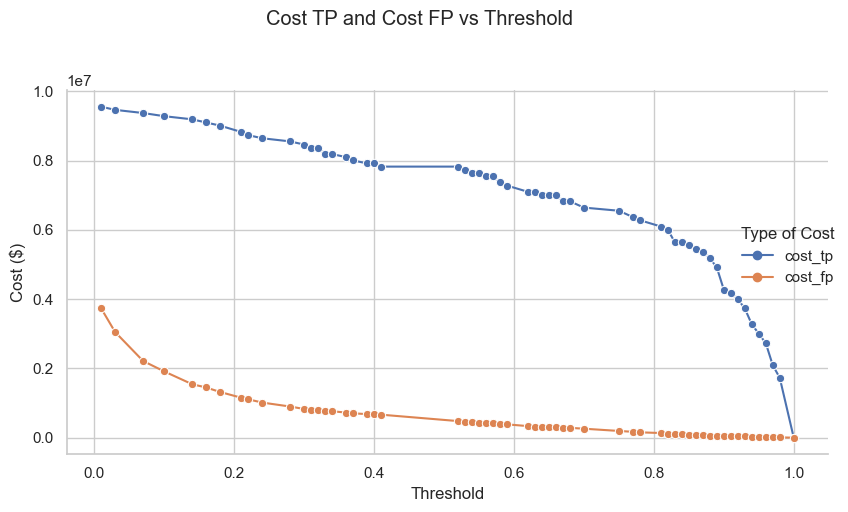

In [181]:
# 1) Melt the two cost columns into long form
df_cost = df_sorted.melt(
    id_vars='threshold',
    value_vars=['cost_tp', 'cost_fp'],
    var_name='CostType',
    value_name='Cost'
)

# 2) Set Seaborn’s theme
sns.set_theme(style="whitegrid")

# 3) Draw the two lines
g = sns.relplot(
    data=df_cost,
    kind="line",
    x="threshold", y="Cost",
    hue="CostType",
    marker="o",         # show point markers
    dashes=False,       # solid lines
    height=5,           # figure height in inches
    aspect=1.5          # width = aspect * height
)

# 4) Tweak labels & title
g.set_axis_labels("Threshold", "Cost ($)")
g.fig.suptitle("Cost TP and Cost FP vs Threshold", y=1.02)
g._legend.set_title("Type of Cost")

plt.tight_layout()
plt.show()

In [182]:
#df_sorted.drop(columns = ['tp_cost_person'], inplace= True )

In [183]:
df_sorted

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,1.00,0.9285,0.0000,0.0000,0.0000,0,0,895,105,0,17325000,0,17325000,0.000000,-9555000.0,-4475000.0,9555000.0,-0.468341
2,0.01,0.9285,0.1232,1.0000,0.2194,105,747,148,0,9555000,0,3735000,13290000,0.140562,91000.0,380000.0,-91000.0,-4.175824
4,0.03,0.9285,0.1457,0.9905,0.2540,104,610,285,1,9464000,165000,3050000,12679000,0.170492,91000.0,345000.0,-91000.0,-3.791209
8,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
11,0.10,0.9285,0.2103,0.9714,0.3458,102,383,512,3,9282000,495000,1915000,11692000,0.266319,91000.0,110000.0,-91000.0,-1.208791
15,0.14,0.9285,0.2463,0.9619,0.3922,101,309,586,4,9191000,660000,1545000,11396000,0.326861,91000.0,55000.0,-91000.0,-0.604396
17,0.16,0.9285,0.2564,0.9524,0.4040,100,290,605,5,9100000,825000,1450000,11375000,0.344828,91000.0,50000.0,-91000.0,-0.549451
19,0.18,0.9285,0.2727,0.9429,0.4231,99,264,631,6,9009000,990000,1320000,11319000,0.375000,182000.0,45000.0,-182000.0,-0.247253
22,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000,0.419913,91000.0,45000.0,-91000.0,-0.494505
23,0.22,0.9285,0.3019,0.9143,0.4539,96,222,673,9,8736000,1485000,1110000,11331000,0.432432,91000.0,35000.0,-91000.0,-0.384615


Best 'intersection' threshold: 0.77
threshold    0.7700
precision    0.6731
recall       0.6667
f1           0.6699
spread       0.0064
Name: 78, dtype: float64


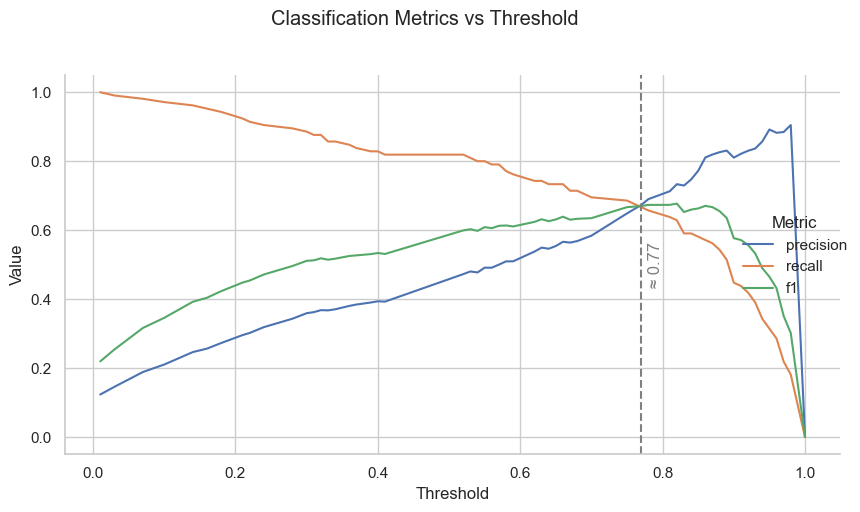

In [184]:
# 1) Melt into long form
df_melt = (
    df_sorted
    .melt(id_vars='threshold',
          value_vars=['precision', 'recall', 'f1'],
          var_name='Metric',
          value_name='Value')
)

# 2) Plot with relplot
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=df_melt,
    kind="line",
    x="threshold", y="Value",
    hue="Metric",
    height=5, aspect=1.5,
    markers=True, dashes=False,
)
g.set_axis_labels("Threshold", "Value")
g.fig.suptitle("Classification Metrics vs Threshold", y=1.02)
g._legend.set_title("Metric")

# 3) Compute spread (excluding endpoints 0.0 and 1.0)
df_mid = df_sorted[(df_sorted['threshold'] > 0.0) & (df_sorted['threshold'] < 1.0)].copy()
df_mid['spread'] = (
    df_mid[['precision', 'recall', 'f1']].max(axis=1) -
    df_mid[['precision', 'recall', 'f1']].min(axis=1)
)

# 4) Find the threshold with the smallest spread
best_idx = df_mid['spread'].idxmin()
best_row = df_mid.loc[best_idx, ['threshold', 'precision', 'recall', 'f1', 'spread']]
best_thresh = best_row['threshold']

print("Best 'intersection' threshold:", best_thresh)
print(best_row)

# 5) Annotate on the plot
ax = g.ax
ax.axvline(best_thresh, color='gray', linestyle='--')
ax.text(
    x=best_thresh + 0.01,
    y=0.5,
    s=f"≈ {best_thresh:.2f}",
    rotation=90,
    va='center',
    color='gray'
)

plt.tight_layout()
plt.show()

In [185]:
#df_sorted.drop(columns = ['spread'], inplace= True )

In [186]:
df_sorted


,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,1.00,0.9285,0.0000,0.0000,0.0000,0,0,895,105,0,17325000,0,17325000,0.000000,-9555000.0,-4475000.0,9555000.0,-0.468341
2,0.01,0.9285,0.1232,1.0000,0.2194,105,747,148,0,9555000,0,3735000,13290000,0.140562,91000.0,380000.0,-91000.0,-4.175824
4,0.03,0.9285,0.1457,0.9905,0.2540,104,610,285,1,9464000,165000,3050000,12679000,0.170492,91000.0,345000.0,-91000.0,-3.791209
8,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
11,0.10,0.9285,0.2103,0.9714,0.3458,102,383,512,3,9282000,495000,1915000,11692000,0.266319,91000.0,110000.0,-91000.0,-1.208791
15,0.14,0.9285,0.2463,0.9619,0.3922,101,309,586,4,9191000,660000,1545000,11396000,0.326861,91000.0,55000.0,-91000.0,-0.604396
17,0.16,0.9285,0.2564,0.9524,0.4040,100,290,605,5,9100000,825000,1450000,11375000,0.344828,91000.0,50000.0,-91000.0,-0.549451
19,0.18,0.9285,0.2727,0.9429,0.4231,99,264,631,6,9009000,990000,1320000,11319000,0.375000,182000.0,45000.0,-182000.0,-0.247253
22,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000,0.419913,91000.0,45000.0,-91000.0,-0.494505
23,0.22,0.9285,0.3019,0.9143,0.4539,96,222,673,9,8736000,1485000,1110000,11331000,0.432432,91000.0,35000.0,-91000.0,-0.384615


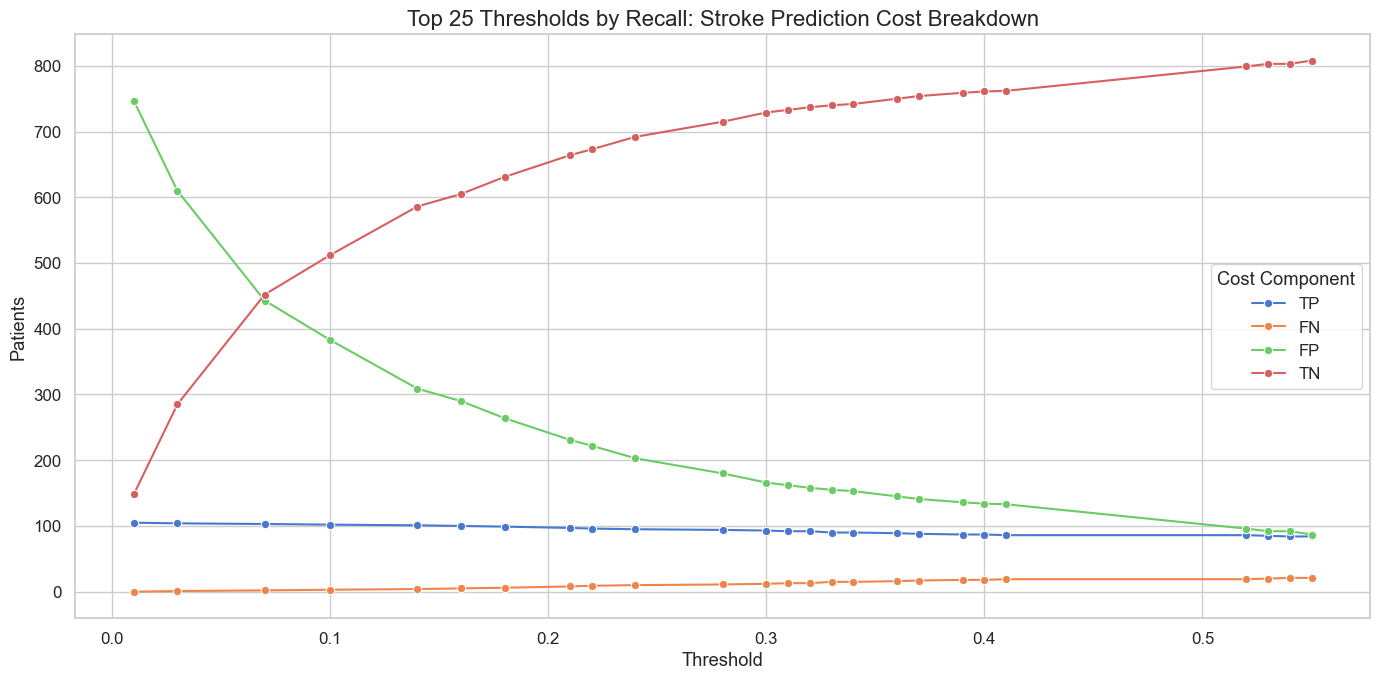

In [187]:
# Sort and reshape the data
top25 = df_sorted.sort_values("recall", ascending=False).head(25)

# Melt the DataFrame to long format for Seaborn
df_melted = top25.melt(
    id_vars="threshold",
    value_vars=["TP", "FN", "FP", "TN"],
    var_name="Cost Type",
    value_name="Cost"
)

# Set Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Create the lineplot
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_melted, x="threshold", y="Cost", hue="Cost Type", marker="o")

# Enhance plot
plt.title("Top 25 Thresholds by Recall: Stroke Prediction Cost Breakdown", fontsize=16)
plt.xlabel("Threshold")
plt.ylabel("Patients")
plt.legend(title="Cost Component")
plt.tight_layout()
plt.show()

In [188]:
df_sorted


,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,1.00,0.9285,0.0000,0.0000,0.0000,0,0,895,105,0,17325000,0,17325000,0.000000,-9555000.0,-4475000.0,9555000.0,-0.468341
2,0.01,0.9285,0.1232,1.0000,0.2194,105,747,148,0,9555000,0,3735000,13290000,0.140562,91000.0,380000.0,-91000.0,-4.175824
4,0.03,0.9285,0.1457,0.9905,0.2540,104,610,285,1,9464000,165000,3050000,12679000,0.170492,91000.0,345000.0,-91000.0,-3.791209
8,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
11,0.10,0.9285,0.2103,0.9714,0.3458,102,383,512,3,9282000,495000,1915000,11692000,0.266319,91000.0,110000.0,-91000.0,-1.208791
15,0.14,0.9285,0.2463,0.9619,0.3922,101,309,586,4,9191000,660000,1545000,11396000,0.326861,91000.0,55000.0,-91000.0,-0.604396
17,0.16,0.9285,0.2564,0.9524,0.4040,100,290,605,5,9100000,825000,1450000,11375000,0.344828,91000.0,50000.0,-91000.0,-0.549451
19,0.18,0.9285,0.2727,0.9429,0.4231,99,264,631,6,9009000,990000,1320000,11319000,0.375000,182000.0,45000.0,-182000.0,-0.247253
22,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000,0.419913,91000.0,45000.0,-91000.0,-0.494505
23,0.22,0.9285,0.3019,0.9143,0.4539,96,222,673,9,8736000,1485000,1110000,11331000,0.432432,91000.0,35000.0,-91000.0,-0.384615


In [189]:
df_sorted

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,1.00,0.9285,0.0000,0.0000,0.0000,0,0,895,105,0,17325000,0,17325000,0.000000,-9555000.0,-4475000.0,9555000.0,-0.468341
2,0.01,0.9285,0.1232,1.0000,0.2194,105,747,148,0,9555000,0,3735000,13290000,0.140562,91000.0,380000.0,-91000.0,-4.175824
4,0.03,0.9285,0.1457,0.9905,0.2540,104,610,285,1,9464000,165000,3050000,12679000,0.170492,91000.0,345000.0,-91000.0,-3.791209
8,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
11,0.10,0.9285,0.2103,0.9714,0.3458,102,383,512,3,9282000,495000,1915000,11692000,0.266319,91000.0,110000.0,-91000.0,-1.208791
15,0.14,0.9285,0.2463,0.9619,0.3922,101,309,586,4,9191000,660000,1545000,11396000,0.326861,91000.0,55000.0,-91000.0,-0.604396
17,0.16,0.9285,0.2564,0.9524,0.4040,100,290,605,5,9100000,825000,1450000,11375000,0.344828,91000.0,50000.0,-91000.0,-0.549451
19,0.18,0.9285,0.2727,0.9429,0.4231,99,264,631,6,9009000,990000,1320000,11319000,0.375000,182000.0,45000.0,-182000.0,-0.247253
22,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000,0.419913,91000.0,45000.0,-91000.0,-0.494505
23,0.22,0.9285,0.3019,0.9143,0.4539,96,222,673,9,8736000,1485000,1110000,11331000,0.432432,91000.0,35000.0,-91000.0,-0.384615


In [196]:
selected_thresholds = [0.07,0.28, 0.37, 0.52, 0.77]

# 2) Filter and copy into a new DataFrame
df_selected = df_sorted[df_sorted['threshold'].isin(selected_thresholds)].copy()

# 3) (Optional) Reset the index if you like
df_selected.reset_index(drop=True, inplace=True)

In [197]:
df_selected

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
1,0.28,0.9285,0.3431,0.8952,0.4960,94,180,715,11,8554000,1815000,900000,11269000,0.522222,91000.0,40000.0,-91000.0,-0.439560
2,0.37,0.9285,0.3843,0.8381,0.5269,88,141,754,17,8008000,2805000,705000,11518000,0.624113,91000.0,25000.0,-91000.0,-0.274725
3,0.52,0.9285,0.4725,0.8190,0.5993,86,96,799,19,7826000,3135000,480000,11441000,0.895833,182000.0,20000.0,-182000.0,-0.109890
4,0.77,0.9285,0.6731,0.6667,0.6699,70,34,861,35,6370000,5775000,170000,12315000,2.058824,91000.0,15000.0,-91000.0,-0.164835


In [198]:
df_selected

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
1,0.28,0.9285,0.3431,0.8952,0.4960,94,180,715,11,8554000,1815000,900000,11269000,0.522222,91000.0,40000.0,-91000.0,-0.439560
2,0.37,0.9285,0.3843,0.8381,0.5269,88,141,754,17,8008000,2805000,705000,11518000,0.624113,91000.0,25000.0,-91000.0,-0.274725
3,0.52,0.9285,0.4725,0.8190,0.5993,86,96,799,19,7826000,3135000,480000,11441000,0.895833,182000.0,20000.0,-182000.0,-0.109890
4,0.77,0.9285,0.6731,0.6667,0.6699,70,34,861,35,6370000,5775000,170000,12315000,2.058824,91000.0,15000.0,-91000.0,-0.164835


In [199]:
df_sorted

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,1.00,0.9285,0.0000,0.0000,0.0000,0,0,895,105,0,17325000,0,17325000,0.000000,-9555000.0,-4475000.0,9555000.0,-0.468341
2,0.01,0.9285,0.1232,1.0000,0.2194,105,747,148,0,9555000,0,3735000,13290000,0.140562,91000.0,380000.0,-91000.0,-4.175824
4,0.03,0.9285,0.1457,0.9905,0.2540,104,610,285,1,9464000,165000,3050000,12679000,0.170492,91000.0,345000.0,-91000.0,-3.791209
8,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
11,0.10,0.9285,0.2103,0.9714,0.3458,102,383,512,3,9282000,495000,1915000,11692000,0.266319,91000.0,110000.0,-91000.0,-1.208791
15,0.14,0.9285,0.2463,0.9619,0.3922,101,309,586,4,9191000,660000,1545000,11396000,0.326861,91000.0,55000.0,-91000.0,-0.604396
17,0.16,0.9285,0.2564,0.9524,0.4040,100,290,605,5,9100000,825000,1450000,11375000,0.344828,91000.0,50000.0,-91000.0,-0.549451
19,0.18,0.9285,0.2727,0.9429,0.4231,99,264,631,6,9009000,990000,1320000,11319000,0.375000,182000.0,45000.0,-182000.0,-0.247253
22,0.21,0.9285,0.2957,0.9238,0.4480,97,231,664,8,8827000,1320000,1155000,11302000,0.419913,91000.0,45000.0,-91000.0,-0.494505
23,0.22,0.9285,0.3019,0.9143,0.4539,96,222,673,9,8736000,1485000,1110000,11331000,0.432432,91000.0,35000.0,-91000.0,-0.384615


- 25k per hospitalization stroke related 
- 140k lifetime cost if had stroke

- TP People that will have Stroke - 11k + (4k * rest of life)
- TN People that will not have Stroke -  0
- FP People that is diagnost to have a Stroke - 5k on tests
- FN People that are miss diagnost and will have Stroke - 25k and 140k

In [200]:
df_selected

,threshold,auc,precision,recall,f1,TP,FP,TN,FN,cost_tp,cost_fn,cost_fp,total_cost,identification_ratio,delta_cost_tp,delta_cost_fp,delta_tp,extra_fp_cost_per_tp
0,0.07,0.9285,0.1886,0.9810,0.3164,103,443,452,2,9373000,330000,2215000,11918000,0.232506,91000.0,120000.0,-91000.0,-1.318681
1,0.28,0.9285,0.3431,0.8952,0.4960,94,180,715,11,8554000,1815000,900000,11269000,0.522222,91000.0,40000.0,-91000.0,-0.439560
2,0.37,0.9285,0.3843,0.8381,0.5269,88,141,754,17,8008000,2805000,705000,11518000,0.624113,91000.0,25000.0,-91000.0,-0.274725
3,0.52,0.9285,0.4725,0.8190,0.5993,86,96,799,19,7826000,3135000,480000,11441000,0.895833,182000.0,20000.0,-182000.0,-0.109890
4,0.77,0.9285,0.6731,0.6667,0.6699,70,34,861,35,6370000,5775000,170000,12315000,2.058824,91000.0,15000.0,-91000.0,-0.164835


In [195]:
# in tableau filter by treshold and show people saved and peole miss diagnosed 